# Курсовая работа: Технологии анализа данных
## Тема: Разработка системы машинного обучения для выявления крупномасштабных структур Вселенной на графах галактического распределения

### 1. Выбор набора данных и описание задачи
Первоначально планировалось использовать каталог Euclid, однако в доступном файле (`EUC_MER_FINAL-CAT_TILE102018211-CC66F6_20241018T214045.289017Z_00.00.fits`) не удалось обнаружить столбец с красными смещениями (redshift), который является критически важным для 3D-анализа.

В связи с этим, **производится смена набора данных на каталог SDSS (Sloan Digital Sky Survey)**. Будет использован файл `DataSets/spAll-v6_0_4.fits`, который, как ожидается, содержит необходимые параметры галактик, включая их пространственные координаты (RA, Dec) и красные смещения (z).

**Задача остается прежней:** Разработать систему машинного обучения для идентификации и классификации крупномасштабных структур Вселенной (таких как филаменты, войды, скопления галактик и галактические стены) на основе графового представления распределения галактик. Это включает в себя построение графа по каталогу галактик, применение методов машинного обучения (включая обучение на графах и кластеризацию) для выделения этих структур, и последующую физическую интерпретацию полученных результатов.

In [ ]:
import os
import numpy as np
import pandas as pd
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go 
import plotly.express as px

from astropy import coordinates
import astropy.units as u

import networkx as nx

from sklearn.cluster import DBSCAN, SpectralClustering, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import SpectralEmbedding 

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk") 

import time

print("Libraries imported.")

Libraries imported.


### 2. Предварительный анализ и очистка данных (Каталог SDSS)

На этом этапе мы загрузим данные из файла SDSS `spAll-v6_0_4.fits` и проведем первоначальный осмотр.
Особое внимание уделим наличию и характеристикам столбцов с координатами (`RA`, `DEC`) и красным смещением (`Z`).

In [ ]:
# Ячейка 5 -  загрузка SDSS spAll
fits_file_path = os.path.join("DataSets", "spAll-v6_0_4.fits")
df = pd.DataFrame() 

print(f"Attempting to load FITS file from: {fits_file_path}")

try:
    with fits.open(fits_file_path) as hdul:
        print("--- FITS File Info ---")
        hdul.info()
        print("----------------------")
        
        main_data_hdu_index = -1
        if len(hdul) > 1 and isinstance(hdul[1], (fits.BinTableHDU, fits.TableHDU)):
            main_data_hdu_index = 1
            print(f"Assuming data is in HDU at index 1 (Name: {hdul[1].name if hdul[1].name else 'N/A'})")
        
        if main_data_hdu_index != -1:
            data_astro_full = Table(hdul[main_data_hdu_index].data)
            print(f"\nSuccessfully loaded full Astropy Table from HDU index {main_data_hdu_index} (Name: {hdul[main_data_hdu_index].name if hdul[main_data_hdu_index].name else 'N/A'})")
            print(f"Full Astropy Table: {len(data_astro_full)} objects, {len(data_astro_full.colnames)} columns")
           
            ra_col_name_in_fits = None 
            dec_col_name_in_fits = None

            # Попытка найти стандартные имена, если не указаны
            if not ra_col_name_in_fits:
                for name_candidate in ['PLUG_RA', 'RA']:
                    if name_candidate in data_astro_full.colnames:
                        ra_col_name_in_fits = name_candidate
                        print(f"Auto-detected RA column: {ra_col_name_in_fits}")
                        break
            if not dec_col_name_in_fits:
                for name_candidate in ['PLUG_DEC', 'DEC']:
                    if name_candidate in data_astro_full.colnames:
                        dec_col_name_in_fits = name_candidate
                        print(f"Auto-detected DEC column: {dec_col_name_in_fits}")
                        break
            
            if not ra_col_name_in_fits or not dec_col_name_in_fits:
                print("CRITICAL ERROR: RA or DEC column name could not be determined. Please set them manually in the code.")
                # Вывод всех имен для помощи
                print("\n--- All Column Names from FITS ---")
                print(", ".join(data_astro_full.colnames))
                print("------------------------------------")

            required_cols = [
                ra_col_name_in_fits, 
                dec_col_name_in_fits,
                'Z_NOQSO', 
                'Z_ERR_NOQSO', 
                'ZWARNING_NOQSO', 
                'CLASS_NOQSO',
                'SUBCLASS_NOQSO', 
                'SPECOBJID'
            ]
            
            
            actual_cols_to_select = []
            print("\nChecking required columns for Pandas conversion:")
            for col in required_cols:
                if col and col in data_astro_full.colnames:
                    actual_cols_to_select.append(col)
                    print(f"  '{col}' - OK")
                elif col: 
                    print(f"  WARNING: Column '{col}' not found in FITS table!")

            if not actual_cols_to_select or not ra_col_name_in_fits or not dec_col_name_in_fits or 'Z_NOQSO' not in actual_cols_to_select:
                 print("CRITICAL: Not enough key columns found to proceed. Cannot convert to Pandas DataFrame meaningfully.")
            else:
                data_astro_selected = data_astro_full[actual_cols_to_select]
                print(f"\nSelected {len(data_astro_selected.colnames)} columns for Pandas conversion.")
                print("--- First 5 rows of SELECTED Astropy Table ---")
                try:
                    data_astro_selected.show_in_notebook(display_length=5)
                except:
                    data_astro_selected.pprint_all(max_lines=5, max_width=200)
                
                df = data_astro_selected.to_pandas()
                print("\n\n--- Pandas DataFrame Info (first 5 rows of SELECTED columns) ---")
                pd.set_option('display.max_columns', None) 
                print(df.head())
                pd.reset_option('display.max_columns')
                print("-----------------------------------------------------------------")

        else:
            print("Could not find a suitable data HDU in the FITS file.")

except FileNotFoundError:
    print(f"ERROR: FITS file not found at {fits_file_path}")
except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()


print(f"\nFinal DataFrame shape: {df.shape}")
if df.empty:
    print("DataFrame is empty. Data loading or conversion to Pandas might have failed.")
else:
    print("Pandas DataFrame loaded successfully with selected columns.")

Attempting to load FITS file from: DataSets/spAll-v6_0_4.fits
--- FITS File Info ---
Filename: DataSets/spAll-v6_0_4.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    267   23500R x 125C   [6A, 17A, 7A, 4A, E, E, J, J, E, J, E, E, E, B, B, J, I, 5E, 5E, E, E, E, 48A, 5E, I, I, I, I, E, J, I, 68A, E, 11A, 143A, 95A, 95A, 95A, 119A, 142A, E, 4E, 3E, 2E, E, E, E, E, E, E, E, E, E, E, E, E, K, K, J, J, J, J, 6A, 6A, 16A, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, 5E, E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, 16A, 9A, 12A, E, E, E, E, E, E, E, E, J, E, E, J, J, 6A, 21A, E, K]   
----------------------
Assuming data is in HDU at index 1 (Name: N/A)

Successfully loaded full Astropy Table from HDU index 1 (Name: N/A)
Full Astropy Table: 23500 objects, 125 columns
Auto-detected RA column: PLUG_RA
Auto-detected DEC column: PLUG_DEC

Checking

##### 2.1 Описание атрибутов данных (SDSS)

In [ ]:
# Ячейка 7 - Код для анализа, статистики и фильтрации SDSS
actual_ra_col = None
actual_dec_col = None
actual_z_col = None
actual_id_col = None 
actual_class_col = None
actual_z_err_col = None
actual_zwarning_col = None


if not df.empty:
    print("--- Missing Values per Column (showing columns with >0 missing) ---")
    if 'data_astro_selected' in globals():
         selected_cols_for_df = [col for col in [
                                    'PLUG_RA', 'PLUG_DEC', 'Z_NOQSO', 'Z_ERR_NOQSO', 
                                    'ZWARNING_NOQSO', 'CLASS_NOQSO', 'SUBCLASS_NOQSO', 'SPECOBJID'
                                ] if col in data_astro_selected.colnames]
         if selected_cols_for_df:
             df = data_astro_selected[selected_cols_for_df].to_pandas()
             print("Refreshed df from data_astro_selected for safety.")
         else:
             print("Warning: data_astro_selected does not contain expected columns to refresh df.")


    missing_values = df.isnull().sum()
    missing_values_report = missing_values[missing_values > 0]
    if not missing_values_report.empty:
        with pd.option_context('display.max_rows', 100): 
            print(missing_values_report)
    else:
        if df.empty or all(df[col].isnull().all() for col in df.columns):
            print("DataFrame appears to be entirely empty or all columns are full of NaNs.")
        else:
            print("No missing values found in any of the currently selected DataFrame columns.")
    print("---------------------------------------------------------------------\n")

    # Имена столбцов для SDSS spAll
    potential_ra_cols = ['PLUG_RA', 'RA'] 
    potential_dec_cols = ['PLUG_DEC', 'DEC']
    # Z_NOQSO подтвержден как основной для красного смещения
    potential_z_cols = ['Z_NOQSO'] 
    potential_z_err_cols = ['Z_ERR_NOQSO'] # Точное имя из вывода
    potential_zwarning_cols = ['ZWARNING_NOQSO'] # Точное имя из вывода
    potential_id_cols = ['SPECOBJID'] 
    potential_class_cols = ['CLASS_NOQSO', 'CLASS'] # CLASS_NOQSO подтвержден

    identified_key_cols = []

    def find_and_assign_col(potentials, var_name_str, df_cols, is_critical=False):
        for p_col in potentials:
            if p_col in df_cols:
                globals()[var_name_str] = p_col
                identified_key_cols.append(p_col)
                print(f"Identified {var_name_str.replace('actual_', '').replace('_col','').upper()} column: {p_col}")
                return True
        warning_level = "CRITICAL WARNING" if is_critical else "Warning"
        print(f"{warning_level}: Could not automatically identify {var_name_str.replace('actual_', '').replace('_col','').upper()} column from: {potentials}")
        return False

    find_and_assign_col(potential_ra_cols, 'actual_ra_col', df.columns, is_critical=True)
    find_and_assign_col(potential_dec_cols, 'actual_dec_col', df.columns, is_critical=True)
    find_and_assign_col(potential_z_cols, 'actual_z_col', df.columns, is_critical=True) 
    find_and_assign_col(potential_class_cols, 'actual_class_col', df.columns, is_critical=True) 
    find_and_assign_col(potential_id_cols, 'actual_id_col', df.columns) 
    
    find_and_assign_col(potential_z_err_cols, 'actual_z_err_col', df.columns)
    find_and_assign_col(potential_zwarning_cols, 'actual_zwarning_col', df.columns)
            
    if identified_key_cols:
        print("\n--- Basic Statistics for Key Columns ---")
        cols_for_describe = [col for col in [actual_ra_col, actual_dec_col, actual_z_col, actual_z_err_col] if col and col in df.columns]
        if cols_for_describe:
             print(df[cols_for_describe].describe())
        else:
            print("No key columns were successfully identified for statistics.")
        print("----------------------------------------")
        
        if actual_class_col and actual_class_col in df.columns:
            print(f"\n--- Value Counts for {actual_class_col} ---")
            print(df[actual_class_col].value_counts(dropna=False))
            print("------------------------------------")
        if actual_zwarning_col and actual_zwarning_col in df.columns:
            print(f"\n--- Value Counts for {actual_zwarning_col} (0 means good redshift) ---")
            if pd.api.types.is_numeric_dtype(df[actual_zwarning_col]):
                print(df[actual_zwarning_col].value_counts(dropna=False).sort_index())
            else:
                print(f"Warning: {actual_zwarning_col} is not numeric, cannot sort index properly for display.")
                print(df[actual_zwarning_col].value_counts(dropna=False))
            print("------------------------------------------------------------------")
    
    df_original_for_filtering = df.copy()
    df_filtered = df_original_for_filtering.copy()

    initial_count = len(df_filtered)
    print(f"\nInitial number of objects for filtering: {initial_count}")

    if actual_class_col and actual_class_col in df_filtered.columns:
        df_filtered[actual_class_col] = df_filtered[actual_class_col].astype(str).str.upper().str.strip()
        df_filtered = df_filtered[df_filtered[actual_class_col] == 'GALAXY']
        print(f"After filtering by {actual_class_col} == 'GALAXY': {len(df_filtered)} objects")
    else:
        print(f"Warning: CLASS column ('{actual_class_col}') not found, cannot filter by object type.")

    if actual_z_col and actual_z_col in df_filtered.columns:
        df_filtered = df_filtered[np.isfinite(df_filtered[actual_z_col])]
        # Для SDSS Z может быть немного отрицательным из-за ошибок, но для LSS обычно интересуют z > ~0.01 или z > 0
        # Оставим z > 0
        df_filtered = df_filtered[df_filtered[actual_z_col] > 0] 
        print(f"After filtering by {actual_z_col} > 0 and finite: {len(df_filtered)} objects")
        
        if actual_zwarning_col and actual_zwarning_col in df_filtered.columns:
            # Убедимся, что сравниваем с числом, если ZWARNING_NOQSO числовой
            if pd.api.types.is_numeric_dtype(df_filtered[actual_zwarning_col]):
                df_filtered = df_filtered[df_filtered[actual_zwarning_col] == 0]
                print(f"After filtering by {actual_zwarning_col} == 0: {len(df_filtered)} objects")
            else:
                print(f"Warning: {actual_zwarning_col} is not numeric, cannot reliably filter by ZWARNING == 0.")
        else:
            print(f"Warning: ZWARNING column ('{actual_zwarning_col}') not found, cannot filter by redshift quality flag.")
        

    else:
        print(f"CRITICAL WARNING: Redshift column ('{actual_z_col}') not found or not usable. 3D analysis will be impossible.")

    final_count = len(df_filtered)
    print(f"\nTotal objects selected for analysis: {final_count} (out of initial {len(df_original_for_filtering) if not df_original_for_filtering.empty else 'N/A'})")
    
    if final_count > 0 :
        df = df_filtered.copy()
        print("Main DataFrame 'df' has been updated with filtered data.")
    elif initial_count > 0 and final_count == 0 : # Если были объекты, но все отфильтровались
        print("CRITICAL WARNING: Filtering resulted in zero objects. Check filter conditions.")
        print("Reverting 'df' to its state before filtering for now to allow inspection.")
        df = df_original_for_filtering.copy()
    else:
        print("No effective filtering applied or DataFrame was empty/unchanged by filtering.")

else:
    print("DataFrame is empty. Cannot perform missing value check, statistics, or filtering.")


--- Missing Values per Column (showing columns with >0 missing) ---
Refreshed df from data_astro_selected for safety.
No missing values found in any of the currently selected DataFrame columns.
---------------------------------------------------------------------

Identified RA column: PLUG_RA
Identified DEC column: PLUG_DEC
Identified Z column: Z_NOQSO
Identified CLASS column: CLASS_NOQSO
Identified ID column: SPECOBJID
Identified Z_ERR column: Z_ERR_NOQSO
Identified ZWARNING column: ZWARNING_NOQSO

--- Basic Statistics for Key Columns ---
            PLUG_RA      PLUG_DEC       Z_NOQSO   Z_ERR_NOQSO
count  23500.000000  23500.000000  23500.000000  23500.000000
mean     136.818967      1.742214      0.291310      0.065117
std        4.717289      2.004233      0.268945      3.519842
min      126.827450     -2.483830     -0.011447     -6.000000
25%      132.999100     -0.009701      0.002605      0.000041
50%      136.714965      1.894816      0.264693      0.000091
75%      141.074680


--- Visualizing Key Distributions (Filtered SDSS Data) ---


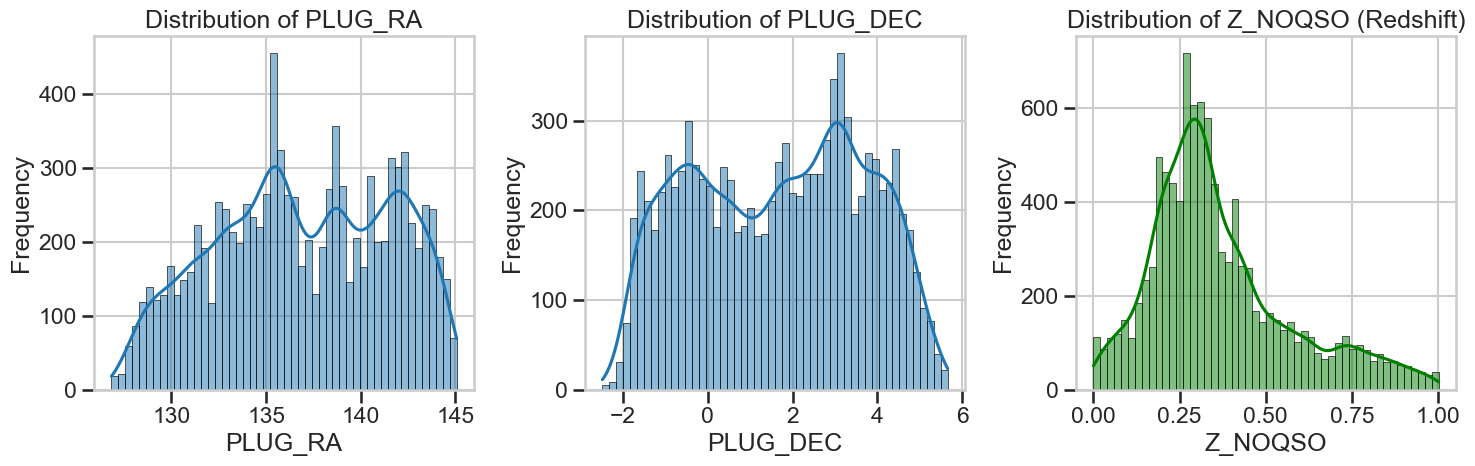

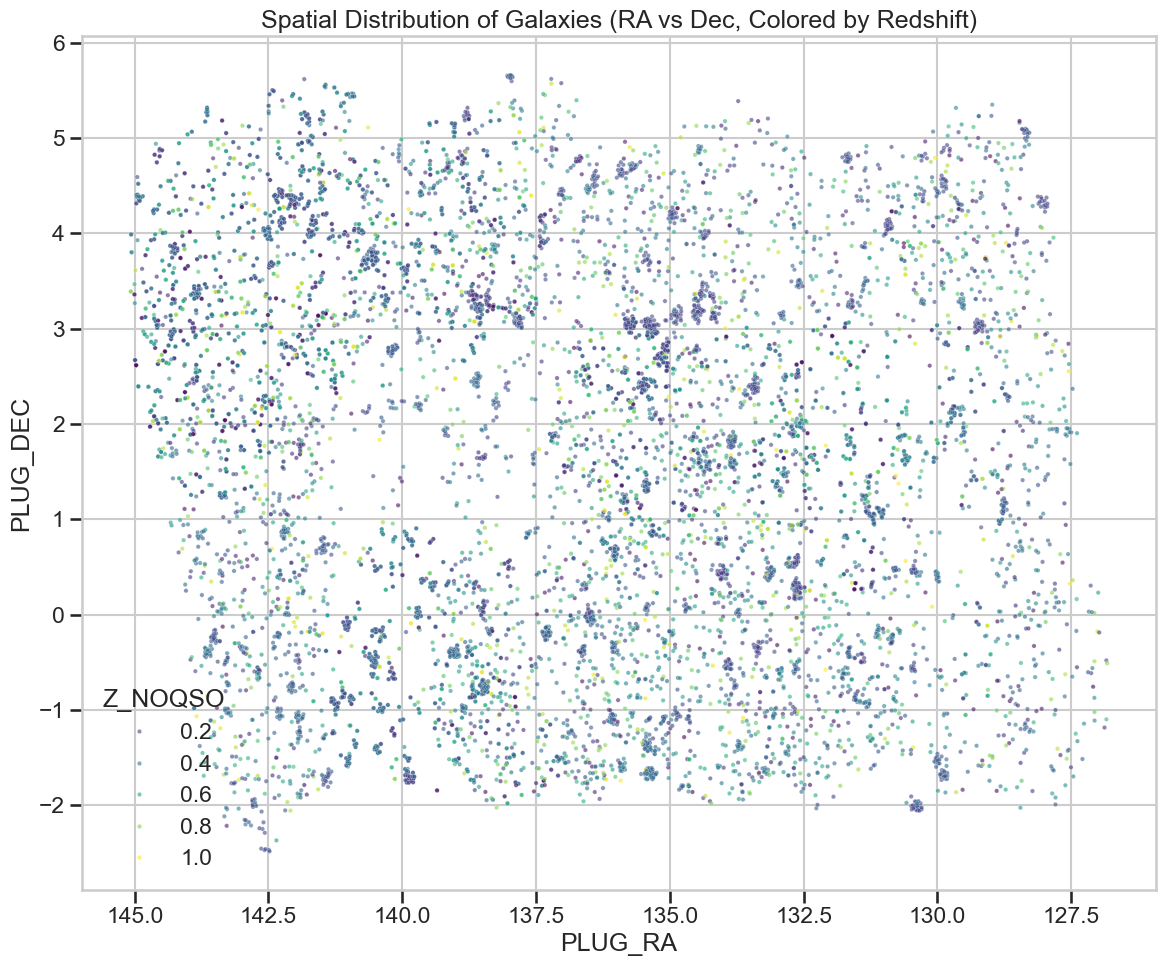


--- End of SDSS Data Analysis and Visualization ---


In [ ]:
# Ячейка 8 - Построение графиков

if not df.empty and actual_ra_col and actual_dec_col and actual_z_col:
    print("\n--- Visualizing Key Distributions (Filtered SDSS Data) ---")
    
    plot_ra = actual_ra_col in df.columns
    plot_dec = actual_dec_col in df.columns
    plot_z = actual_z_col in df.columns

    num_plots = sum([plot_ra, plot_dec, plot_z])
    if num_plots == 0:
        print("No key columns (RA, Dec, Z) available for plotting.")
    else:
        fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5), squeeze=False) # squeeze=False чтобы axes всегда был 2D
        current_ax = 0
        if plot_ra:
            sns.histplot(df[actual_ra_col], kde=True, bins=50, ax=axes[0, current_ax])
            axes[0, current_ax].set_title(f'Distribution of {actual_ra_col}')
            axes[0, current_ax].set_xlabel(actual_ra_col)
            axes[0, current_ax].set_ylabel('Frequency')
            current_ax += 1
        if plot_dec:
            sns.histplot(df[actual_dec_col], kde=True, bins=50, ax=axes[0, current_ax])
            axes[0, current_ax].set_title(f'Distribution of {actual_dec_col}')
            axes[0, current_ax].set_xlabel(actual_dec_col)
            axes[0, current_ax].set_ylabel('Frequency')
            current_ax += 1
        if plot_z:
            sns.histplot(df[actual_z_col], kde=True, bins=50, color='green', ax=axes[0, current_ax])
            axes[0, current_ax].set_title(f'Distribution of {actual_z_col} (Redshift)')
            axes[0, current_ax].set_xlabel(actual_z_col)
            axes[0, current_ax].set_ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()
        
    if plot_ra and plot_dec and plot_z:
        plt.figure(figsize=(12, 10))
        sample_df = df.sample(n=min(50000, len(df)), random_state=42) if len(df) > 50000 else df
            
        scatter_plot = sns.scatterplot(x=actual_ra_col, y=actual_dec_col, 
                                   hue=actual_z_col, 
                                   data=sample_df, 
                                   s=10, alpha=0.6, 
                                   palette='viridis',
                                   legend='auto')
        plt.title('Spatial Distribution of Galaxies (RA vs Dec, Colored by Redshift)')
        plt.xlabel(actual_ra_col)
        plt.ylabel(actual_dec_col)
        
        try:
            current_xlim = plt.xlim()
            if current_xlim[0] < current_xlim[1]: 
                 plt.xlim(max(current_xlim), min(current_xlim))
        except Exception as e_ax:
            print(f"Note: Could not invert RA axis: {e_ax}")
            
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    elif plot_ra and plot_dec:
        print("\nRedshift column not available for coloring the RA/Dec scatter plot.")
        plt.figure(figsize=(10, 8))
        sample_df = df.sample(n=min(50000, len(df)), random_state=42) if len(df) > 50000 else df
        sns.scatterplot(x=actual_ra_col, y=actual_dec_col, data=sample_df, s=10, alpha=0.6)
        plt.title('Spatial Distribution of Galaxies (RA vs Dec)')
        plt.xlabel(actual_ra_col)
        plt.ylabel(actual_dec_col)
        try:
            current_xlim = plt.xlim()
            if current_xlim[0] < current_xlim[1]: 
                 plt.xlim(max(current_xlim), min(current_xlim))
        except Exception as e_ax:
            print(f"Note: Could not invert RA axis: {e_ax}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
else:
    print("DataFrame is empty or key coordinate/redshift columns not identified. Skipping visualizations.")

print("\n--- End of SDSS Data Analysis and Visualization ---")

#### Преобразование координат в декартовы

--- Преобразование небесных координат в декартовы (x, y, z) ---
Добавлены столбцы: 'x_coord', 'y_coord', 'z_cart_coord'

Первые 5 строк DataFrame с декартовыми координатами:
             SPECOBJID    PLUG_RA  PLUG_DEC   Z_NOQSO   x_coord   y_coord  \
1 -1397241080191365120  128.76442  1.079786  0.295897 -0.185234  0.230678   
2 -1397240805313458176  128.74327  1.196445  0.292022 -0.182717  0.227715   
3 -1397240530435551232  128.83884  0.952081  0.284723 -0.178534  0.221744   
5 -1397239980679737344  128.82615  0.974811  0.348983 -0.218767  0.271837   
7 -1397239430923923456  128.76036  1.119119  0.288663 -0.180687  0.225048   

   z_cart_coord  
1      0.005576  
2      0.006098  
3      0.004731  
5      0.005937  
7      0.005638  

--- Статистика по декартовым координатам ---
            x_coord       y_coord  z_cart_coord
count  10067.000000  10067.000000  10067.000000
mean      -0.266943      0.249758      0.010498
std        0.151295      0.142675      0.015932
min       -0.7998

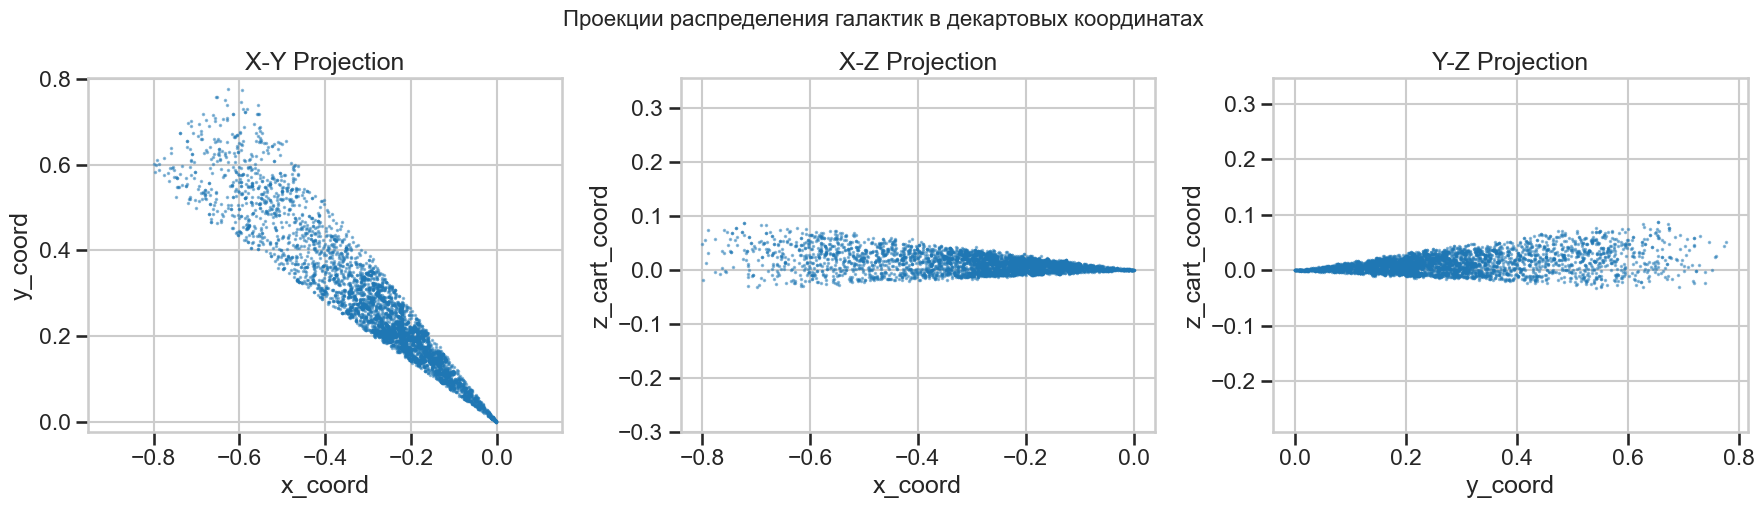

In [ ]:
# Ячейка 9 - Преобразование координат
if not df.empty and actual_ra_col and actual_dec_col and actual_z_col:
    print("--- Преобразование небесных координат в декартовы (x, y, z) ---")
    
    
    ra_rad = np.deg2rad(df[actual_ra_col])
    dec_rad = np.deg2rad(df[actual_dec_col])
    
    radial_dist = df[actual_z_col]
    
    if (radial_dist <= 0).any():
        print(f"Warning: Found non-positive values in '{actual_z_col}' used as radial distance. Count: {(radial_dist <= 0).sum()}")

        
    # Вычисление декартовых координат
    # Используем z_cart для z-координаты, чтобы не путать с красным смещением z
    x_coord = radial_dist * np.cos(dec_rad) * np.cos(ra_rad)
    y_coord = radial_dist * np.cos(dec_rad) * np.sin(ra_rad)
    z_cart_coord = radial_dist * np.sin(dec_rad)
    
    df['x_coord'] = x_coord
    df['y_coord'] = y_coord
    df['z_cart_coord'] = z_cart_coord
    
    print(f"Добавлены столбцы: 'x_coord', 'y_coord', 'z_cart_coord'")
    print("\nПервые 5 строк DataFrame с декартовыми координатами:")
    
    cols_to_show = [actual_ra_col, actual_dec_col, actual_z_col, 'x_coord', 'y_coord', 'z_cart_coord']
    if actual_id_col and actual_id_col in df.columns:
        cols_to_show.insert(0, actual_id_col)
        
    existing_cols_to_show = [col for col in cols_to_show if col in df.columns]

    with pd.option_context('display.max_columns', None):
        print(df[existing_cols_to_show].head())
    
    print("\n--- Статистика по декартовым координатам ---")
    print(df[['x_coord', 'y_coord', 'z_cart_coord']].describe())
    print("---------------------------------------------")

    # Визуализация проекций 
    fig_scatter_cart, axes_scatter_cart = plt.subplots(1, 3, figsize=(18, 5))
    sample_df_cart = df.sample(n=min(5000, len(df)), random_state=42) # Уменьшенная выборка для скорости

    axes_scatter_cart[0].scatter(sample_df_cart['x_coord'], sample_df_cart['y_coord'], s=1, alpha=0.5)
    axes_scatter_cart[0].set_xlabel('x_coord')
    axes_scatter_cart[0].set_ylabel('y_coord')
    axes_scatter_cart[0].set_title('X-Y Projection')
    axes_scatter_cart[0].axis('equal')

    axes_scatter_cart[1].scatter(sample_df_cart['x_coord'], sample_df_cart['z_cart_coord'], s=1, alpha=0.5)
    axes_scatter_cart[1].set_xlabel('x_coord')
    axes_scatter_cart[1].set_ylabel('z_cart_coord')
    axes_scatter_cart[1].set_title('X-Z Projection')
    axes_scatter_cart[1].axis('equal')

    axes_scatter_cart[2].scatter(sample_df_cart['y_coord'], sample_df_cart['z_cart_coord'], s=1, alpha=0.5)
    axes_scatter_cart[2].set_xlabel('y_coord')
    axes_scatter_cart[2].set_ylabel('z_cart_coord')
    axes_scatter_cart[2].set_title('Y-Z Projection')
    axes_scatter_cart[2].axis('equal')

    plt.tight_layout()
    plt.suptitle('Проекции распределения галактик в декартовых координатах', fontsize=16, y=1.03)
    plt.show()

else:
    print("DataFrame 'df' пуст или не определены ключевые столбцы (RA, Dec, Z). Преобразование координат невозможно.")


### 3. Построение графа галактического распределения

На основе полученных декартовых координат (x, y, z) для каждой галактики из отфильтрованного каталога SDSS мы построим пространственный граф.

**Определение графа:**
*   **Узлы (вершины):** Каждая галактика в нашем отфильтрованном наборе данных будет являться узлом графа.
*   **Ребра (связи):** Ребро будет соединять две галактики, если евклидово расстояние между ними в 3D пространстве меньше некоторого заранее определенного порогового значения, называемого "длиной связи" (`linking length`, \(r_{link}\)).

**Выбор длины связи (\(r_{link}\)):**
Выбор этого параметра является важным шагом.
*   Слишком маленькое значение \(r_{link}\) приведет к очень разреженному графу, где большинство галактик будут изолированы или образовывать лишь небольшие группы.
*   Слишком большое значение \(r_{link}\) приведет к очень плотному, "пересвязанному" графу, где все или почти все галактики будут соединены друг с другом, что затруднит выделение отдельных структур.
Значение \(r_{link}\) обычно выбирается исходя из характерных масштабов исследуемых структур или на основе анализа распределения расстояний между ближайшими соседями. Для начала мы выберем некоторое разумное значение, а затем, при необходимости, сможем его варьировать. Масштабы могут зависеть от того, что `Z_NOQSO` использовалось как прямое расстояние; если бы мы использовали космологические расстояния в Мпк, \(r_{link}\) был бы порядка нескольких Мпк (например, 5-10 Мпк/ч). Поскольку наши "расстояния" сейчас напрямую связаны с z, наш \(r_{link}\) также будет в этих "единицах z".

**Инструменты:**
Для построения и анализа графа будет использоваться библиотека Python `networkx`.

In [ ]:
# Ячейка 11 - Построение графа на основе пространственного распределения галактик

if not df.empty and 'x_coord' in df.columns and 'y_coord' in df.columns and 'z_cart_coord' in df.columns:
    print("--- Построение графа ---")
    
    coordinates_3d = df[['x_coord', 'y_coord', 'z_cart_coord']].values
    galaxy_ids = df[actual_id_col].values if actual_id_col and actual_id_col in df.columns else np.arange(len(df))

    # Параметр: длина связи (linking length)
    # Начнем с r_link = 0.02 (в "единицах z")
    # Если среднее z ~0.3, то 0.02 это примерно 1/15 от этого значения.
    # Масштаб x,y,z координат примерно равен масштабу z.
    r_link = 0.02 
    print(f"Используемая длина связи (r_link): {r_link}")

    G = nx.Graph()

    # Каждый узел - это галактика, атрибуты узла - ее координаты
    for i in range(len(df)):
        G.add_node(galaxy_ids[i], 
                   pos=(coordinates_3d[i, 0], coordinates_3d[i, 1], coordinates_3d[i, 2]),
                   ra=df[actual_ra_col].iloc[i] if actual_ra_col in df.columns else None,
                   dec=df[actual_dec_col].iloc[i] if actual_dec_col in df.columns else None,
                   z=df[actual_z_col].iloc[i] if actual_z_col in df.columns else None
                  )
    
    print(f"Добавлено узлов в граф: {G.number_of_nodes()}")

    # Добавление ребер на основе расстояния
    # Это может быть вычислительно затратно для >10k точек (~N^2/2 сравнений)
    # Для ускорения можно использовать структуры данных типа KDTree из scipy.spatial
    # Но для начала попробуем прямой перебор для наглядности, если точек не слишком много.
    
    print("Начинаем добавление ребер (это может занять время)...")
    start_time_edges = time.time()

    # Преобразуем узлы в список для итерации, чтобы избежать изменения словаря во время итерации
    nodes_list = list(G.nodes(data=True))

    for i in range(len(nodes_list)):
        for j in range(i + 1, len(nodes_list)):
            node1_id, data1 = nodes_list[i]
            node2_id, data2 = nodes_list[j]
            
            pos1 = np.array(data1['pos'])
            pos2 = np.array(data2['pos'])
            
            distance = np.sqrt(np.sum((pos1 - pos2)**2))
            
            if distance < r_link:
                G.add_edge(node1_id, node2_id, weight=distance) 

    end_time_edges = time.time()
    print(f"Добавление ребер завершено. Время: {end_time_edges - start_time_edges:.2f} секунд.")
    print(f"Количество ребер в графе: {G.number_of_edges()}")

    if G.number_of_nodes() > 0:
        print(f"Средняя степень узла: {np.mean([d for n, d in G.degree()]) if G.number_of_edges() > 0 else 0:.2f}")
        
        if nx.is_connected(G) if G.number_of_nodes() > 0 and G.number_of_edges() > 0 else False: # is_connected требует непустой граф
            print("Граф является связным.")
        else:
            num_connected_components = nx.number_connected_components(G)
            print(f"Граф не является связным. Количество компонент связности: {num_connected_components}")
            if num_connected_components > 1:
                largest_cc = max(nx.connected_components(G), key=len)
                print(f"Размер наибольшей компоненты связности: {len(largest_cc)} узлов")
    else:
        print("Граф не содержит узлов.")

    nx.write_graphml(G, "galaxy_graph.graphml")
    print("Граф сохранен в файл galaxy_graph.graphml")

else:
    print("DataFrame 'df' пуст или отсутствуют декартовы координаты. Построение графа невозможно.")


--- Построение графа ---
Используемая длина связи (r_link): 0.02
Добавлено узлов в граф: 10067
Начинаем добавление ребер (это может занять время)...
Добавление ребер завершено. Время: 243.67 секунд.
Количество ребер в графе: 975991
Средняя степень узла: 193.90
Граф не является связным. Количество компонент связности: 122
Размер наибольшей компоненты связности: 9723 узлов


In [ ]:
# Ячейка 12 - Выявление наибольшей компоненты связности (LCC)

if 'G' not in locals() or G.number_of_nodes() == 0:
    print("Граф G не найден или пуст. Пожалуйста, сначала выполните ячейку 11 (Построение графа).")
    G_lcc = nx.Graph() 
    df_lcc = pd.DataFrame()
    nodes_lcc = []
else:
    connected_components = list(nx.connected_components(G))
    
    if not connected_components:
        print("Граф G не имеет компонент связности (возможно, он пуст или состоит из изолированных узлов).")
        G_lcc = nx.Graph()
        df_lcc = pd.DataFrame()
        nodes_lcc = []
    else:
        largest_cc_nodes = max(connected_components, key=len)
        G_lcc = G.subgraph(largest_cc_nodes).copy() 
        
        nodes_lcc = list(G_lcc.nodes()) 
        
        print(f"Количество узлов в исходном графе G: {G.number_of_nodes()}")
        print(f"Количество ребер в исходном графе G: {G.number_of_edges()}")
        print(f"Количество компонент связности в G: {len(connected_components)}")
        print(f"Количество узлов в наибольшей компоненте связности (G_lcc): {G_lcc.number_of_nodes()}")
        print(f"Количество ребер в наибольшей компоненте связности (G_lcc): {G_lcc.number_of_edges()}")

        if not df.index.name == 'SPECOBJID' and 'SPECOBJID' in df.columns:
            print("Индекс DataFrame 'df' не является 'SPECOBJID'. Устанавливаем 'SPECOBJID' как индекс.")
            if df['SPECOBJID'].is_unique:
                df.set_index('SPECOBJID', inplace=True)
            else:
                print("ОШИБКА: 'SPECOBJID' не уникален, не может быть установлен как индекс. LCC DataFrame не будет создан.")
                df_lcc = pd.DataFrame()
        elif not df.index.name == 'SPECOBJID':
             print("ОШИБКА: Индекс DataFrame 'df' не 'SPECOBJID' и такой колонки нет. LCC DataFrame не будет создан.")
             df_lcc = pd.DataFrame()

        if df.index.name == 'SPECOBJID':
            missing_nodes = [node for node in nodes_lcc if node not in df.index]
            if missing_nodes:
                print(f"ВНИМАНИЕ: {len(missing_nodes)} узлов из LCC не найдены в индексе 'df'. Эти узлы будут проигнорированы в 'df_lcc'.")
                nodes_lcc_in_df = [node for node in nodes_lcc if node in df.index]
                df_lcc = df.loc[nodes_lcc_in_df].copy() 
            else:
                df_lcc = df.loc[nodes_lcc].copy()
            
            print(f"Создан DataFrame 'df_lcc' с {df_lcc.shape[0]} объектами и {df_lcc.shape[1]} признаками.")
            if not df_lcc.empty:
                print("\nПервые 5 строк 'df_lcc':")
                print(df_lcc.head())
            else:
                print("'df_lcc' пуст. Проверьте, соответствуют ли узлы графа индексам в 'df'.")
        else:
            print("DataFrame 'df_lcc' не может быть создан, так как 'SPECOBJID' не является индексом в 'df'.")
            if 'df_lcc' not in locals():
                 df_lcc = pd.DataFrame()


if 'G_lcc' not in locals() or G_lcc.number_of_nodes() == 0:
    print("\nПРЕДУПРЕЖДЕНИЕ: G_lcc не был успешно создан или пуст.")
    if 'G_lcc' not in locals(): G_lcc = nx.Graph() # создаем пустой, чтобы не было ошибки в след. ячейках
    if 'df_lcc' not in locals(): df_lcc = pd.DataFrame() # создаем пустой
    if 'nodes_lcc' not in locals(): nodes_lcc = []
else:
    print(f"\nПроверка: G_lcc содержит {G_lcc.number_of_nodes()} узлов и {G_lcc.number_of_edges()} ребер.")

if 'df_lcc' not in locals() or df_lcc.empty:
     print("ПРЕДУПРЕЖДЕНИЕ: df_lcc не был успешно создан или пуст.")
     if 'df_lcc' not in locals(): df_lcc = pd.DataFrame()
else:
    print(f"Проверка: df_lcc содержит {df_lcc.shape[0]} строк.")


--- Извлечение наибольшей компоненты связности (LCC) ---
Количество узлов в исходном графе G: 10067
Количество ребер в исходном графе G: 975991
Количество компонент связности в G: 122
Количество узлов в наибольшей компоненте связности (G_lcc): 9723
Количество ребер в наибольшей компоненте связности (G_lcc): 975541
Индекс DataFrame 'df' не является 'SPECOBJID'. Устанавливаем 'SPECOBJID' как индекс.
Создан DataFrame 'df_lcc' с 9723 объектами и 10 признаками.

Первые 5 строк 'df_lcc':
                        PLUG_RA  PLUG_DEC   Z_NOQSO  Z_ERR_NOQSO  \
SPECOBJID                                                          
-1397241080191365120  128.76442  1.079786  0.295897     0.000089   
-1397240805313458176  128.74327  1.196445  0.292022     0.000050   
-1397240530435551232  128.83884  0.952081  0.284723     0.000036   
-1397239980679737344  128.82615  0.974811  0.348983     0.000116   
-1397239430923923456  128.76036  1.119119  0.288663     0.000046   

                      ZWARNING_NOQSO

### 3.3. Алгоритмы кластеризации и анализа графа (Обновление для Главы 3 Методологии)

После построения графа пространственного распределения галактик, основной задачей становится выявление в нем связных подструктур, которые могут соответствовать реальным космологическим образованиям (скопления, филаменты). Для этого будут применены алгоритмы кластеризации, адаптированные для работы с графовыми данными или с координатами узлов.

Основное внимание будет уделено наибольшей компоненте связности (LCC) графа, так как она содержит подавляющее большинство узлов (~96.6% при `r_link = 0.02`) и представляет собой наиболее протяженную связанную структуру в данных.

Планируется использовать следующие подходы (согласно методическим указаниям, для задач классификации/кластеризации нужно рассмотреть несколько алгоритмов):

1.  **DBSCAN (Density-Based Spatial Clustering of Applications with Noise):**
    *   Этот алгоритм хорошо подходит для поиска кластеров произвольной формы и может выделять шумовые точки (галактики, не принадлежащие ни к одному плотному скоплению).
    *   Будет применяться непосредственно к декартовым координатам галактик (`x_coord`, `y_coord`, `z_cart_coord`), входящих в LCC.
    *   Ключевые гиперпараметры: `eps` (максимальное расстояние между образцами, чтобы один считался соседом другого) и `min_samples` (минимальное количество образцов в окрестности точки, чтобы она считалась ядром кластера). Значение `eps` будет сопоставимо с нашим `r_link` или меньше.

2.  **Спектральная кластеризация (Spectral Clustering):**
    *   Этот метод использует собственные значения матрицы Лапласа графа для выполнения понижения размерности перед применением кластеризации (например, k-means) в новом пространстве.
    *   Может быть эффективен для поиска хорошо разделенных кластеров.
    *   Будет применяться к матрице смежности LCC.
    *   Ключевой гиперпараметр: `n_clusters` (количество искомых кластеров).

3.  **Агломеративная кластеризация (Agglomerative Clustering):**
    *   Иерархический алгоритм кластеризации, который последовательно объединяет кластеры.
    *   Может быть применен к координатам узлов LCC.
    *   Ключевые гиперпараметры: `n_clusters` (количество искомых кластеров) и `linkage` (критерий объединения кластеров, например, 'ward', 'complete', 'average').

**Подготовка данных для кластеризации:**
*   Для DBSCAN и Агломеративной кластеризации будут использоваться непосредственно 3D координаты узлов LCC.
*   Для Спектральной кластеризации будет использоваться подграф LCC.

**Оценка качества кластеризации:**
Будут использованы внутренние метрики оценки качества кластеризации, такие как:
*   **Индекс силуэта (Silhouette Score):** Оценивает, насколько объект похож на свой собственный кластер по сравнению с другими кластерами. Значения от -1 до 1, где более высокие значения указывают на лучшую кластеризацию.
*   **Индекс Дэвиса-Болдина (Davies-Bouldin Index):** Оценивает среднее "сходство" между каждым кластером и его наиболее похожим кластером. Более низкие значения указывают на лучшую кластеризацию (кластеры более раздельны).

Поскольку истинной разметки на кластеры у нас нет, используются внутренние метрики. Физическая интерпретация и визуализация полученных кластеров также будут важны для оценки осмысленности результатов.

Время обучения моделей будет замеряться.

In [ ]:
# Ячейка 13 - Кластеризация DBSCAN на LCC 
if 'G_lcc' in locals() and G_lcc.number_of_nodes() > 0:
    print(f"Размер LCC: {G_lcc.number_of_nodes()} узлов, {G_lcc.number_of_edges()} ребер.")
    
    lcc_nodes_list = list(G_lcc.nodes()) 
    
    if 'df_lcc' in locals() and not df_lcc.empty:
        try:
            coordinates_lcc_ordered = df_lcc.loc[lcc_nodes_list, ['x_coord', 'y_coord', 'z_cart_coord']].values
            print(f"Координаты для DBSCAN получены из DataFrame для {len(coordinates_lcc_ordered)} узлов LCC.")

            # Параметры DBSCAN
            eps_dbscan = 0.02 
            min_samples_dbscan = 10
            print(f"Параметры DBSCAN: eps = {eps_dbscan}, min_samples = {min_samples_dbscan}")

            dbscan = DBSCAN(eps=eps_dbscan, min_samples=min_samples_dbscan)
            
            start_time_dbscan = time.time()
            labels_dbscan = dbscan.fit_predict(coordinates_lcc_ordered)
            end_time_dbscan = time.time() 
            time_dbscan_exec = end_time_dbscan - start_time_dbscan 
            print(f"DBSCAN выполнен. Время: {time_dbscan_exec:.2f} секунд.")
            node_to_label_dbscan = {node_id: label for node_id, label in zip(lcc_nodes_list, labels_dbscan)}

            nx.set_node_attributes(G_lcc, node_to_label_dbscan, 'dbscan_label')
            print("Атрибуты 'dbscan_label' добавлены к узлам графа G_lcc.")

            df_lcc['dbscan_label'] = pd.Series(node_to_label_dbscan, index=lcc_nodes_list)
            print("Столбец 'dbscan_label' добавлен/обновлен в df_lcc.")
            
            n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
            n_noise_dbscan = list(labels_dbscan).count(-1)
            
            print(f"Найдено кластеров (DBSCAN): {n_clusters_dbscan}")
            print(f"Количество шумовых точек (DBSCAN): {n_noise_dbscan} (из {len(coordinates_lcc_ordered)} в LCC)")
            
            if len(coordinates_lcc_ordered) > 1 and n_clusters_dbscan > 1: 
                silhouette_avg_dbscan = silhouette_score(coordinates_lcc_ordered, labels_dbscan)
                davies_bouldin_avg_dbscan = davies_bouldin_score(coordinates_lcc_ordered, labels_dbscan)
                print(f"  Silhouette Score (DBSCAN): {silhouette_avg_dbscan:.3f}")
                print(f"  Davies-Bouldin Index (DBSCAN): {davies_bouldin_avg_dbscan:.3f}")
            elif n_clusters_dbscan <=1:
                 print("  Silhouette Score и Davies-Bouldin Index не могут быть вычислены (слишком мало кластеров).")
            else:
                print("  Недостаточно данных для вычисления метрик.")

            print("\nРаспределение объектов по кластерам (DBSCAN):")
            print(pd.Series(labels_dbscan).value_counts())

        except KeyError as e:
            print(f"Ошибка KeyError при доступе к df_lcc: {e}. Убедитесь, что df_lcc создан и содержит необходимые столбцы и индексы.")
        except Exception as e:
            print(f"Произошла ошибка при выполнении DBSCAN или обработке результатов: {e}")
            import traceback
            print(traceback.format_exc())

    else:
        print("DataFrame 'df_lcc' не найден или пуст. Пропустите DBSCAN.")
else:
    print("Граф G_lcc не найден или пуст. Пожалуйста, выполните ячейку 11 (построение графа) и 12 (извлечение LCC).")


--- Кластеризация DBSCAN на наибольшей компоненте связности (LCC) ---
Размер LCC: 9723 узлов, 975541 ребер.
Координаты для DBSCAN получены из DataFrame для 9723 узлов LCC.
Параметры DBSCAN: eps = 0.02, min_samples = 10
DBSCAN выполнен. Время: 0.12 секунд.
Атрибуты 'dbscan_label' добавлены к узлам графа G_lcc.
Столбец 'dbscan_label' добавлен/обновлен в df_lcc.
Найдено кластеров (DBSCAN): 12
Количество шумовых точек (DBSCAN): 203 (из 9723 в LCC)
  Silhouette Score (DBSCAN): 0.362
  Davies-Bouldin Index (DBSCAN): 1.672

Распределение объектов по кластерам (DBSCAN):
 0     8994
 1      251
-1      203
 7      104
 4       47
 6       36
 11      26
 5       15
 2       14
 8       13
 10       9
 3        7
 9        4
Name: count, dtype: int64


--- Визуализация кластеров DBSCAN в 3D (на основе df_lcc) ---
Масштаб осей установлен одинаковым.


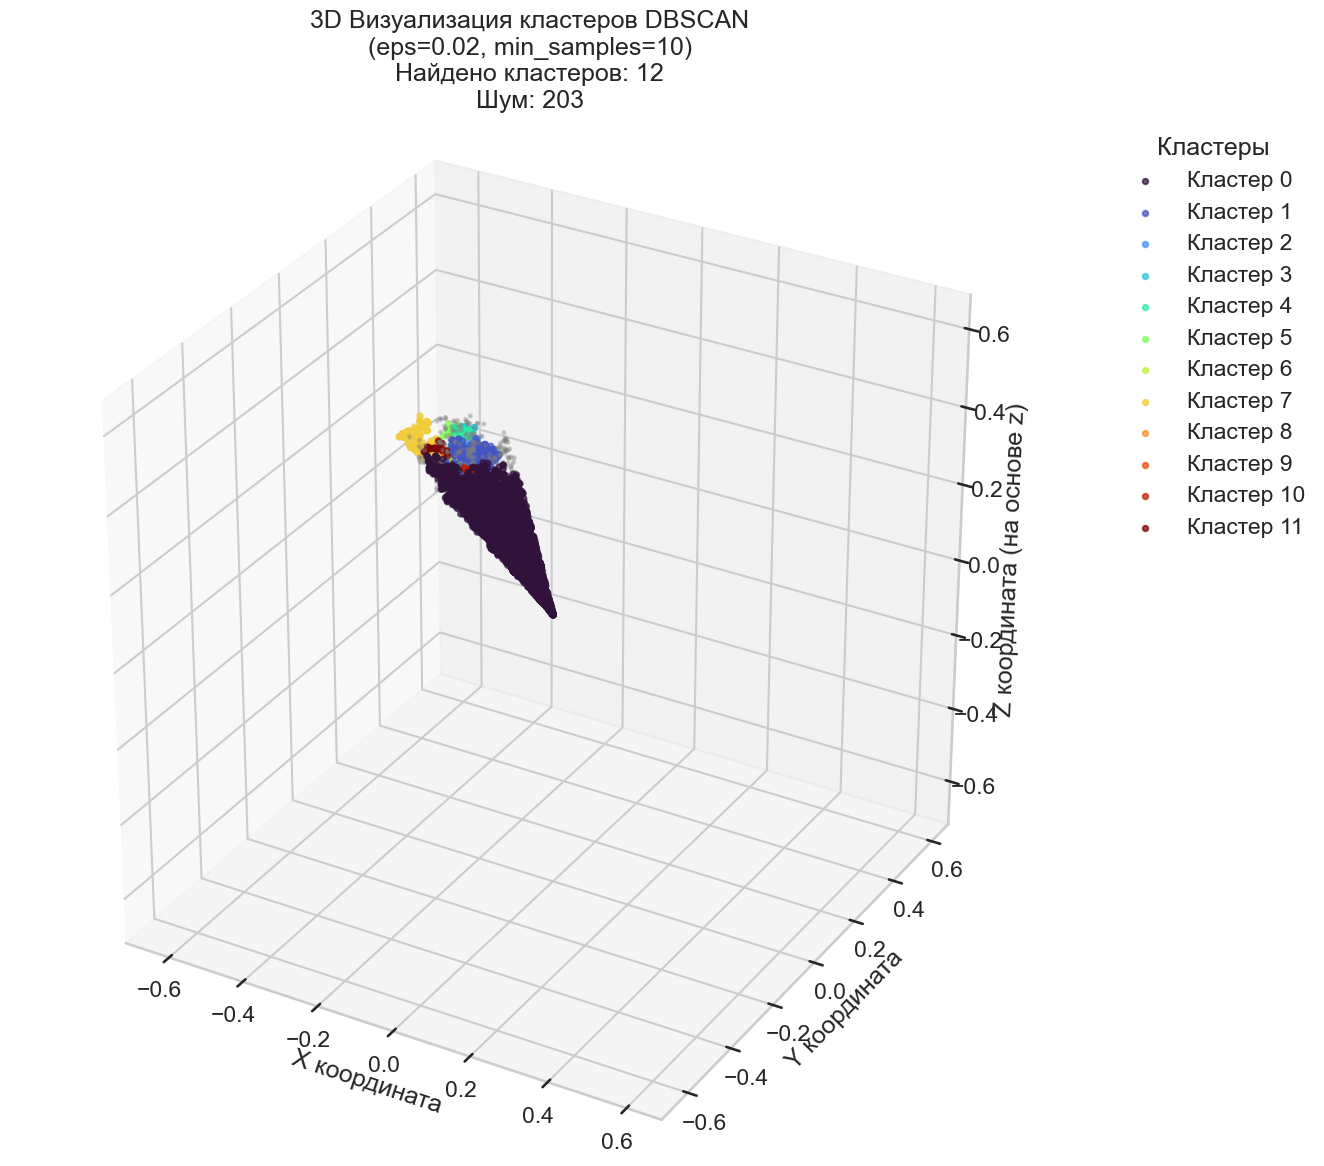

Интерактивный 3D график сохранен в: dbscan_clusters_3d.html


In [27]:
# Ячейка 14 - Визуализация кластеров, найденных DBSCAN

if 'df_lcc' in globals() and 'dbscan_label' in df_lcc.columns and 'x_coord' in df_lcc.columns:
    print("--- Визуализация кластеров DBSCAN в 3D (на основе df_lcc) ---")
    
    df_plot_dbscan = df_lcc[df_lcc['dbscan_label'].notna()].copy() 
    
    if not df_plot_dbscan.empty:
        df_plot_dbscan.loc[:, 'dbscan_label'] = df_plot_dbscan['dbscan_label'].astype(int)

        fig = plt.figure(figsize=(15, 12))
        ax = fig.add_subplot(111, projection='3d')

        unique_labels = sorted(df_plot_dbscan['dbscan_label'].unique())
        n_clusters_to_plot = len([label for label in unique_labels if label != -1])


        colors_map = None
        if n_clusters_to_plot > 0:
            try:
                colors_map = plt.get_cmap('turbo', n_clusters_to_plot) 
            except ValueError:
                 colors_map = plt.get_cmap('turbo') 
        
        sample_df_plot = df_plot_dbscan

        noise_mask = sample_df_plot['dbscan_label'] == -1
        if np.any(noise_mask): 
            ax.scatter(sample_df_plot.loc[noise_mask, 'x_coord'], 
                       sample_df_plot.loc[noise_mask, 'y_coord'], 
                       sample_df_plot.loc[noise_mask, 'z_cart_coord'], 
                       c='gray', label='Шум (-1)', s=5, alpha=0.3)

        cluster_legend_handles = []
        
        cluster_ids_for_coloring = sorted([l for l in unique_labels if l != -1])
        cluster_color_index_map = {label_val: i for i, label_val in enumerate(cluster_ids_for_coloring)}

        for label_val in unique_labels:
            if label_val == -1: 
                continue 
            cluster_mask = sample_df_plot['dbscan_label'] == label_val
            if not np.any(cluster_mask): 
                continue

            current_color = 'blue' 
            if colors_map and n_clusters_to_plot > 0:
                 color_idx_for_map = cluster_color_index_map[label_val]
                 color_value = color_idx_for_map / (n_clusters_to_plot - 1) if n_clusters_to_plot > 1 else 0.5
                 current_color = colors_map(color_value)
            elif colors_map and n_clusters_to_plot == 1: 
                current_color = colors_map(0.5)

            scatter = ax.scatter(sample_df_plot.loc[cluster_mask, 'x_coord'], 
                                 sample_df_plot.loc[cluster_mask, 'y_coord'], 
                                 sample_df_plot.loc[cluster_mask, 'z_cart_coord'], 
                                 color=current_color, 
                                 label=f'Кластер {label_val}', s=15, alpha=0.7)
            cluster_legend_handles.append(scatter)

        ax.set_xlabel('X координата')
        ax.set_ylabel('Y координата')
        ax.set_zlabel('Z координата (на основе z)')
        
        title_parts = ["3D Визуализация кластеров DBSCAN"]
        if "eps_dbscan" in locals() and "min_samples_dbscan" in locals():
            title_parts.append(f"(eps={eps_dbscan}, min_samples={min_samples_dbscan})")
        if "n_clusters_dbscan" in locals():
             title_parts.append(f"Найдено кластеров: {n_clusters_dbscan}") 
        if "labels_dbscan" in locals():
            actual_noise_points = list(labels_dbscan).count(-1)
            title_parts.append(f"Шум: {actual_noise_points}")
        ax.set_title("\n".join(title_parts))
        
        if len(cluster_legend_handles) > 15:
            ax.legend(handles=cluster_legend_handles[:15], title="Кластеры (первые 15)", bbox_to_anchor=(1.05, 1), loc='upper left')
            print("Примечание: В легенде показаны только первые 15 кластеров из-за их большого количества.")
        elif cluster_legend_handles:
             ax.legend(handles=cluster_legend_handles, title="Кластеры", bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Установка одинакового масштаба для осей
        try:
            all_coords_plot = df_plot_dbscan[['x_coord', 'y_coord', 'z_cart_coord']].values.flatten()
            all_coords_plot = all_coords_plot[~np.isnan(all_coords_plot)] 
            if len(all_coords_plot) > 0:
                coord_min, coord_max = np.min(all_coords_plot), np.max(all_coords_plot)
                ax.set_xlim([coord_min, coord_max])
                ax.set_ylim([coord_min, coord_max])
                ax.set_zlim([coord_min, coord_max])
                ax.set_box_aspect([1,1,1])
                print("Масштаб осей установлен одинаковым.")
        except Exception as e_scale:
            print(f"Не удалось установить одинаковый масштаб осей: {e_scale}")

        plt.tight_layout(rect=[0, 0, 0.85, 1]) 
        plt.show()
        
        try:
            interactive_fig_dbscan = go.Figure()
            if np.any(noise_mask):
                interactive_fig_dbscan.add_trace(go.Scatter3d(
                    x=sample_df_plot.loc[noise_mask, 'x_coord'],
                    y=sample_df_plot.loc[noise_mask, 'y_coord'],
                    z=sample_df_plot.loc[noise_mask, 'z_cart_coord'],
                    mode='markers',
                    marker=dict(size=2, color='gray', opacity=0.3),
                    name='Шум (-1)'
                ))
            for label_val in unique_labels:
                if label_val == -1: continue
                cluster_mask = sample_df_plot['dbscan_label'] == label_val
                if not np.any(cluster_mask): continue
                
                current_color_str = 'blue'
                if colors_map and n_clusters_to_plot > 0:
                     color_idx_for_map = cluster_color_index_map[label_val]
                     color_value = color_idx_for_map / (n_clusters_to_plot - 1) if n_clusters_to_plot > 1 else 0.5
                     rgb_color = colors_map(color_value, bytes=False) 
                     current_color_str = f'rgb({int(rgb_color[0]*255)}, {int(rgb_color[1]*255)}, {int(rgb_color[2]*255)})'
                elif colors_map and n_clusters_to_plot == 1:
                     rgb_color = colors_map(0.5, bytes=False)
                     current_color_str = f'rgb({int(rgb_color[0]*255)}, {int(rgb_color[1]*255)}, {int(rgb_color[2]*255)})'

                interactive_fig_dbscan.add_trace(go.Scatter3d(
                    x=sample_df_plot.loc[cluster_mask, 'x_coord'],
                    y=sample_df_plot.loc[cluster_mask, 'y_coord'],
                    z=sample_df_plot.loc[cluster_mask, 'z_cart_coord'],
                    mode='markers',
                    marker=dict(size=3, color=current_color_str, opacity=0.7),
                    name=f'Кластер {label_val}'
                ))
            
            title_str_plotly = f'3D Кластеры DBSCAN (eps={eps_dbscan if "eps_dbscan" in globals() else "N/A"}, min_samples={min_samples_dbscan if "min_samples_dbscan" in globals() else "N/A"})<br>Кл-в: {n_clusters_dbscan if "n_clusters_dbscan" in globals() else "N/A"}, Шум: {list(labels_dbscan).count(-1) if "labels_dbscan" in globals() else "N/A"}'
            interactive_fig_dbscan.update_layout(
                title=title_str_plotly,
                scene=dict(
                    xaxis_title='X координата',
                    yaxis_title='Y координата',
                    zaxis_title='Z координата',
                    aspectmode='cube'
                ),
                margin=dict(l=0, r=0, b=0, t=40)
            )
            interactive_filename_dbscan = "dbscan_clusters_3d.html"
            interactive_fig_dbscan.write_html(interactive_filename_dbscan)
            print(f"Интерактивный 3D график сохранен в: {interactive_filename_dbscan}")

        except Exception as e_plotly:
            print(f"Ошибка при создании интерактивного графика Plotly для DBSCAN: {e_plotly}")


    else:
        print("Нет данных (после фильтрации NaN в dbscan_label) для визуализации кластеров DBSCAN.")
else:
    print("DataFrame 'df_lcc' или необходимые столбцы ('dbscan_label', 'x_coord') не найдены. Визуализация DBSCAN невозможна.")


In [24]:
# Ячейка 14.1 - Исследование влияния eps на DBSCAN

if 'df_lcc' in globals() and not df_lcc.empty and 'x_coord' in df_lcc.columns:
    coordinates_lcc_ordered = df_lcc.loc[list(G_lcc.nodes()), ['x_coord', 'y_coord', 'z_cart_coord']].values
    min_samples_dbscan_fixed = 10
    
    eps_values_to_test = [0.015, 0.02, 0.025, 0.03]
    
    print(f"Тестируемые значения eps (min_samples={min_samples_dbscan_fixed}): {eps_values_to_test}")
    print("-" * 50)
    
    for eps_val in eps_values_to_test:
        print(f"Тестирование DBSCAN с eps = {eps_val}")
        dbscan_test = DBSCAN(eps=eps_val, min_samples=min_samples_dbscan_fixed)
        
        start_time_test = time.time()
        labels_test = dbscan_test.fit_predict(coordinates_lcc_ordered)
        end_time_test = time.time()
        
        n_clusters_test = len(set(labels_test)) - (1 if -1 in labels_test else 0)
        n_noise_test = list(labels_test).count(-1)
        percent_noise_test = (n_noise_test / len(coordinates_lcc_ordered)) * 100
        
        print(f"  Время выполнения: {end_time_test - start_time_test:.2f} секунд.")
        print(f"  Найдено кластеров (не считая шум): {n_clusters_test}")
        print(f"  Количество шумовых точек: {n_noise_test} ({percent_noise_test:.2f}%)")
        
        if len(coordinates_lcc_ordered) > 1 and n_clusters_test > 1:
            try:
                silhouette_avg_test = silhouette_score(coordinates_lcc_ordered, labels_test)
                davies_bouldin_avg_test = davies_bouldin_score(coordinates_lcc_ordered, labels_test)
                print(f"  Silhouette Score: {silhouette_avg_test:.3f}")
                print(f"  Davies-Bouldin Index: {davies_bouldin_avg_test:.3f}")
            except ValueError as e_metrics:
                 print(f"  Не удалось вычислить метрики: {e_metrics} (возможно, все точки в одном кластере или все шум)")
        elif n_clusters_test <=1 :
             print("  Silhouette Score и Davies-Bouldin Index не могут быть вычислены (слишком мало кластеров).")
        else:
            print("  Недостаточно данных для вычисления метрик.")
        print("-" * 30)
    print("--- Завершение исследования eps для DBSCAN ---")
else:
    print("ПРЕДУПРЕЖДЕНИЕ: df_lcc не найден или пуст. Исследование eps для DBSCAN пропущено.")


--- Исследование влияния eps на DBSCAN ---
Тестируемые значения eps (min_samples=10): [0.015, 0.02, 0.025, 0.03]
--------------------------------------------------
Тестирование DBSCAN с eps = 0.015
  Время выполнения: 0.16 секунд.
  Найдено кластеров (не считая шум): 21
  Количество шумовых точек: 919 (9.45%)
  Silhouette Score: 0.206
  Davies-Bouldin Index: 2.433
------------------------------
Тестирование DBSCAN с eps = 0.02
  Время выполнения: 0.12 секунд.
  Найдено кластеров (не считая шум): 12
  Количество шумовых точек: 203 (2.09%)
  Silhouette Score: 0.362
  Davies-Bouldin Index: 1.672
------------------------------
Тестирование DBSCAN с eps = 0.025
  Время выполнения: 0.15 секунд.
  Найдено кластеров (не считая шум): 2
  Количество шумовых точек: 16 (0.16%)
  Silhouette Score: 0.485
  Davies-Bouldin Index: 0.981
------------------------------
Тестирование DBSCAN с eps = 0.03
  Время выполнения: 0.19 секунд.
  Найдено кластеров (не считая шум): 1
  Количество шумовых точек: 0 (0

In [ ]:
# Ячейка 15 - Кластеризация методом Спектральной кластеризации на LCC
start_time_spectral = time.time()

import scipy.sparse

if 'G_lcc' not in locals() or G_lcc.number_of_nodes() == 0:
    print("Граф G_lcc не найден или пуст. Пожалуйста, выполните ячейку 11 (построение графа) и 12 (извлечение LCC).")
    labels_spectral = [] 
    df['spectral_label'] = -2 
    if 'df_lcc' in locals() and isinstance(df_lcc, pd.DataFrame):
        df_lcc['spectral_label'] = -2
else:
    n_clusters_spectral = 8
    print(f"Параметры Спектральной кластеризации: n_clusters = {n_clusters_spectral}")

    try:
        lcc_nodes_list = list(G_lcc.nodes())
        
        adj_matrix_lcc = nx.to_scipy_sparse_array(G_lcc, nodelist=lcc_nodes_list, weight=None, format='csr')
        print(f"Матрица смежности для LCC создана, форма: {adj_matrix_lcc.shape}")

        if not isinstance(adj_matrix_lcc, scipy.sparse.csr_matrix):
             adj_matrix_lcc = adj_matrix_lcc.tocsr()
        
        adj_matrix_lcc.indices = adj_matrix_lcc.indices.astype(np.int32)
        adj_matrix_lcc.indptr = adj_matrix_lcc.indptr.astype(np.int32)
        print("Индексы матрицы смежности преобразованы в np.int32.")

        spectral_clustering = SpectralClustering(
            n_clusters=n_clusters_spectral,
            affinity='precomputed',  
            assign_labels='kmeans', 
            random_state=42,         
            n_init=10,               
            n_jobs=-1                
        )
        
        print("Начинаем обучение SpectralClustering (fit_predict)...")
        labels_spectral = spectral_clustering.fit_predict(adj_matrix_lcc)
        
        if 'df_lcc' in locals() and isinstance(df_lcc, pd.DataFrame) and set(lcc_nodes_list) == set(df_lcc.index):

            spectral_labels_series = pd.Series(labels_spectral, index=lcc_nodes_list)
            df_lcc['spectral_label'] = spectral_labels_series
            
            df['spectral_label'] = -2 # Метка для объектов не в LCC или если кластеризация не удалась
            df.loc[df_lcc.index, 'spectral_label'] = df_lcc['spectral_label'] # Обновляем основной df
            print("Метки спектральной кластеризации добавлены в DataFrame 'df' и 'df_lcc'.")
        else:
            print("ВНИМАНИЕ: DataFrame 'df_lcc' не найден, не является DataFrame, или его индексы не соответствуют узлам G_lcc.")
            print("Метки кластеризации не могут быть корректно сопоставлены с 'df_lcc' и 'df'.")
            df['spectral_label'] = -2 
            if 'labels_spectral' in locals() and len(labels_spectral) > 0:
                 print(f"Получены метки кластеризации (длина {len(labels_spectral)}): {labels_spectral[:10]}...")



        end_time_spectral = time.time()
        execution_time_spectral = end_time_spectral - start_time_spectral
        print(f"Спектральная кластеризация выполнена за {execution_time_spectral:.2f} секунд.")

        n_clusters_found_spectral_ = len(set(labels_spectral))
        print(f"Фактическое количество найденных кластеров (Spectral): {n_clusters_found_spectral_}")

        if n_clusters_found_spectral_ > 1 and len(labels_spectral) == adj_matrix_lcc.shape[0]:
            if 'df_lcc' in locals() and isinstance(df_lcc, pd.DataFrame) and all(col in df_lcc.columns for col in ['x_coord', 'y_coord', 'z_cart_coord']):
                coords_lcc_for_metrics = df_lcc.loc[lcc_nodes_list, ['x_coord', 'y_coord', 'z_cart_coord']].values
                
                if len(labels_spectral) == len(coords_lcc_for_metrics):
                    silhouette_avg_spectral = silhouette_score(coords_lcc_for_metrics, labels_spectral)
                    davies_bouldin_avg_spectral = davies_bouldin_score(coords_lcc_for_metrics, labels_spectral)
                    print(f"Silhouette Score (Spectral): {silhouette_avg_spectral:.4f}")
                    print(f"Davies-Bouldin Index (Spectral): {davies_bouldin_avg_spectral:.4f}")
                else:
                    print("Несоответствие размеров для расчета метрик: метки и координаты LCC.")
            else:
                print("Координаты LCC (df_lcc с x_coord, y_coord, z_cart_coord) не найдены для расчета метрик.")
        elif n_clusters_found_spectral_ <= 1:
            print("Найдено <= 1 кластера, метрики Silhouette и Davies-Bouldin не могут быть рассчитаны.")
        else:
            print("Размеры массива меток и матрицы смежности не совпадают, метрики не рассчитаны.")
            
        print("\nРаспределение объектов по кластерам (Spectral):")
        print(df['spectral_label'].value_counts().sort_index())

    except Exception as e:
        print(f"Ошибка при выполнении Спектральной кластеризации: {e}")
        if 'labels_spectral' not in locals(): 
            labels_spectral = [] 
        if 'df_lcc' in locals() and isinstance(df_lcc, pd.DataFrame):
            df_lcc['spectral_label'] = -2
        df['spectral_label'] = -2
        import traceback
        print(traceback.format_exc())

if 'spectral_label' in df.columns:
    print("\nСтолбец 'spectral_label' присутствует в df.")
    print(f"Значения в 'spectral_label' (первые 5 строк df где метка не -2, если есть):\n{df[df['spectral_label'] != -2]['spectral_label'].head()}")
    if df[df['spectral_label'] != -2].empty:
        print("Все метки 'spectral_label' в df равны -2 (не в LCC или ошибка).")
else:
    print("\nОШИБКА: Столбец 'spectral_label' НЕ присутствует в df.")


--- Кластеризация методом Спектральной кластеризации на LCC ---
Параметры Спектральной кластеризации: n_clusters = 8
Матрица смежности для LCC создана, форма: (9723, 9723)
Индексы матрицы смежности преобразованы в np.int32.
Начинаем обучение SpectralClustering (fit_predict)...
Метки спектральной кластеризации добавлены в DataFrame 'df' и 'df_lcc'.
Спектральная кластеризация выполнена за 6.66 секунд.
Фактическое количество найденных кластеров (Spectral): 8
Silhouette Score (Spectral): 0.4661
Davies-Bouldin Index (Spectral): 0.8590

Распределение объектов по кластерам (Spectral):
spectral_label
-2     344
 0    7930
 1     119
 2      57
 3      55
 4     153
 5     345
 6      61
 7    1003
Name: count, dtype: int64

Столбец 'spectral_label' присутствует в df.
Значения в 'spectral_label' (первые 5 строк df где метка не -2, если есть):
SPECOBJID
-1397241080191365120    0
-1397240805313458176    0
-1397240530435551232    0
-1397239980679737344    0
-1397239430923923456    0
Name: spectral

--- Визуализация результатов Спектральной кластеризации ---


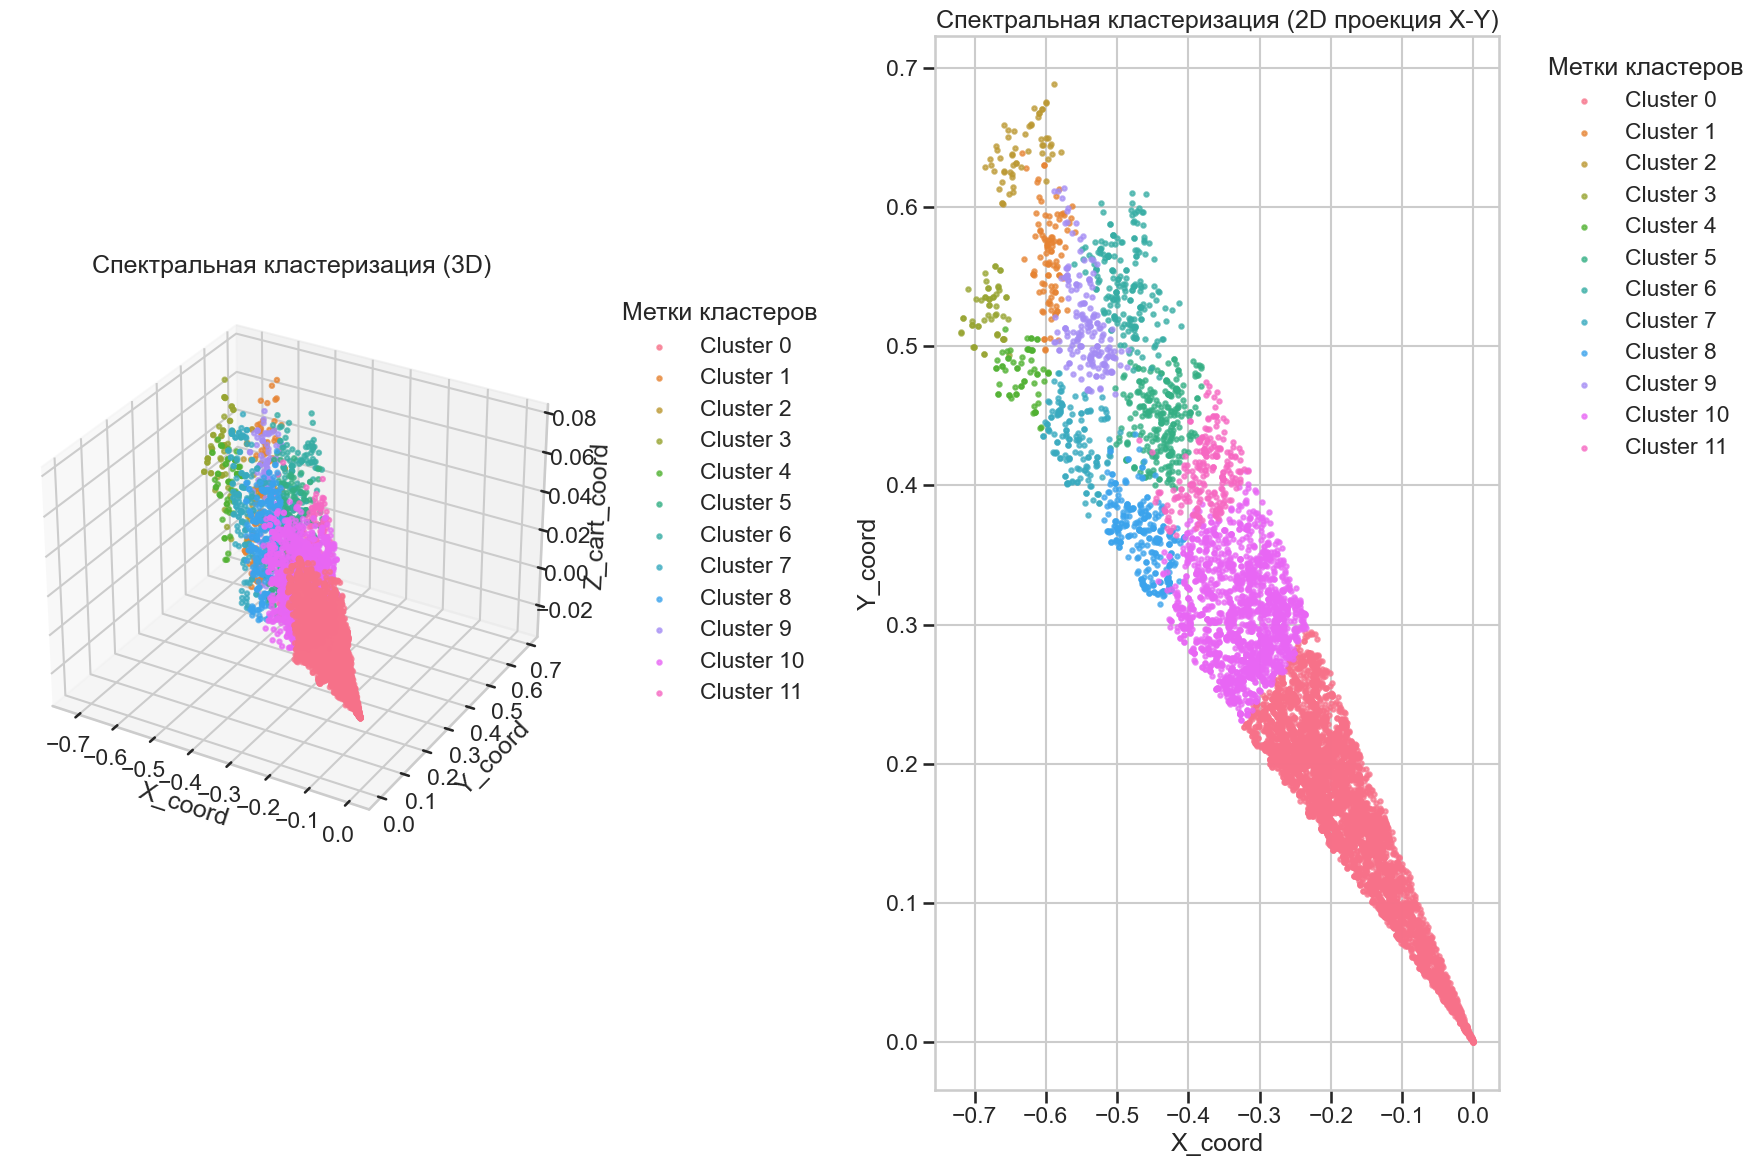


Размеры кластеров (Spectral, исключая не в LCC):
spectral_label
0     6448
1       99
2       57
3       55
4       61
5      246
6      192
7      147
8      281
9      177
10    1726
11     234
Name: count, dtype: int64


In [ ]:
# CELL 16: Visualize Spectral Clustering Results

if 'df' not in locals() or 'spectral_label' not in df.columns:
    print("DataFrame 'df' или столбец 'spectral_label' не найден. Визуализация невозможна.")
elif df[df['spectral_label'] != -2].empty:
    print("Не найдено объектов с валидными метками Spectral Clustering (все метки -2 или LCC пуст). Визуализация невозможна.")
else:
        print("--- Визуализация результатов Спектральной кластеризации ---")
        
        df_plot_spectral = df[df['spectral_label'] != -2].copy() 
    
        if df_plot_spectral.empty:
            print("После фильтрации не осталось объектов для визуализации Spectral Clustering.")
        else:
            fig_spectral = plt.figure(figsize=(18, 12))
            
            ax_3d_spectral = fig_spectral.add_subplot(121, projection='3d')
            unique_labels_spectral = np.unique(df_plot_spectral['spectral_label'])
            palette_spectral = sns.color_palette("husl", num_unique_clusters_spectral)
            
            color_map_spectral = {label: palette_spectral[i] for i, label in enumerate(unique_labels_spectral)}

            for label in unique_labels_spectral:
                cluster_data = df_plot_spectral[df_plot_spectral['spectral_label'] == label]
                ax_3d_spectral.scatter(cluster_data['x_coord'], 
                                       cluster_data['y_coord'], 
                                       cluster_data['z_cart_coord'], 
                                       label=f'Cluster {label}', 
                                       s=10,  
                                       color=color_map_spectral[label],
                                       alpha=0.7)
            
            ax_3d_spectral.set_title('Спектральная кластеризация (3D)')
            ax_3d_spectral.set_xlabel('X_coord')
            ax_3d_spectral.set_ylabel('Y_coord')
            ax_3d_spectral.set_zlabel('Z_cart_coord')
            if num_unique_clusters_spectral > 0 : 
                 ax_3d_spectral.legend(title='Метки кластеров', bbox_to_anchor=(1.05, 1), loc='upper left')
            
            ax_2d_spectral = fig_spectral.add_subplot(122)
            for label in unique_labels_spectral:
                cluster_data = df_plot_spectral[df_plot_spectral['spectral_label'] == label]
                ax_2d_spectral.scatter(cluster_data['x_coord'], 
                                       cluster_data['y_coord'], 
                                       label=f'Cluster {label}', 
                                       s=10,
                                       color=color_map_spectral[label],
                                       alpha=0.7)
            
            ax_2d_spectral.set_title('Спектральная кластеризация (2D проекция X-Y)')
            ax_2d_spectral.set_xlabel('X_coord')
            ax_2d_spectral.set_ylabel('Y_coord')
            if num_unique_clusters_spectral > 0:
                ax_2d_spectral.legend(title='Метки кластеров', bbox_to_anchor=(1.05, 1), loc='upper left')

            plt.tight_layout()
            plt.show()

            # Вывод статистики по кластерам
            print("\nРазмеры кластеров (Spectral, исключая не в LCC):")
            print(df_plot_spectral['spectral_label'].value_counts().sort_index())

Тестируемый диапазон n_clusters: [8, 9, 10, 11, 12, 13, 14, 15, 16]
----------------------------------------------------------------------
Тестирование Spectral Clustering с n_clusters = 8
  Время выполнения: 5.71 секунд.
  Silhouette Score: 0.4661
  Davies-Bouldin Index: 0.8590
----------------------------------------
Тестирование Spectral Clustering с n_clusters = 9
  Время выполнения: 10.85 секунд.
  Silhouette Score: 0.4231
  Davies-Bouldin Index: 0.9444
----------------------------------------
Тестирование Spectral Clustering с n_clusters = 10
  Время выполнения: 5.98 секунд.
  Silhouette Score: 0.4230
  Davies-Bouldin Index: 1.0544
----------------------------------------
Тестирование Spectral Clustering с n_clusters = 11
  Время выполнения: 5.05 секунд.
  Silhouette Score: 0.4127
  Davies-Bouldin Index: 0.9931
----------------------------------------
Тестирование Spectral Clustering с n_clusters = 12
  Время выполнения: 6.89 секунд.
  Silhouette Score: 0.3918
  Davies-Bouldin In

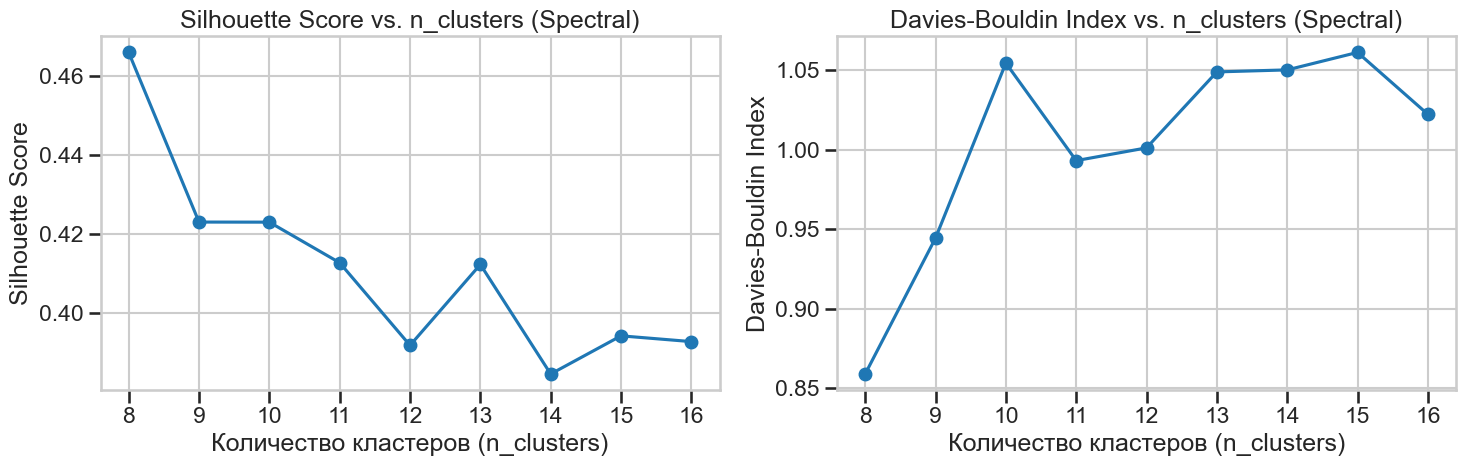


Оптимальное n_clusters по Silhouette Score: 8 (значение: 0.4661)
Оптимальное n_clusters по Davies-Bouldin Index: 8 (значение: 0.8590)
--- Завершение подбора n_clusters для Спектральной кластеризации ---


In [32]:
# Ячейка 16.1 - Подбор n_clusters для Спектральной кластеризации

if 'G_lcc' in globals() and G_lcc.number_of_nodes() > 0 and 'df_lcc' in locals() and not df_lcc.empty:
    if 'adj_matrix_lcc' not in locals():
        print("ПРЕДУПРЕЖДЕНИЕ: Матрица смежности 'adj_matrix_lcc' не найдена. Пропускаем подбор n_clusters.")
    else:
        coordinates_lcc_for_metrics = df_lcc.loc[list(G_lcc.nodes()), ['x_coord', 'y_coord', 'z_cart_coord']].values # Для метрик нужны координаты
        n_clusters_range = range(8, 17)
        
        silhouette_scores_spectral = []
        davies_bouldin_scores_spectral = []
        
        print(f"Тестируемый диапазон n_clusters: {list(n_clusters_range)}")
        print("-" * 70)

        for n_c in n_clusters_range:
            print(f"Тестирование Spectral Clustering с n_clusters = {n_c}")
            spectral_model_test = SpectralClustering(
                n_clusters=n_c,
                affinity='precomputed', 
                assign_labels='kmeans', 
                random_state=42
            )
            
            start_time_sc_test = time.time()
            labels_sc_test = spectral_model_test.fit_predict(adj_matrix_lcc)
            end_time_sc_test = time.time()
            
            print(f"  Время выполнения: {end_time_sc_test - start_time_sc_test:.2f} секунд.")
            
            unique_labels_sc_test = np.unique(labels_sc_test)
            if len(unique_labels_sc_test) > 1 and len(coordinates_lcc_for_metrics) > 1 :
                try:
                    silhouette_avg_sc_test = silhouette_score(coordinates_lcc_for_metrics, labels_sc_test)
                    davies_bouldin_avg_sc_test = davies_bouldin_score(coordinates_lcc_for_metrics, labels_sc_test)
                    silhouette_scores_spectral.append(silhouette_avg_sc_test)
                    davies_bouldin_scores_spectral.append(davies_bouldin_avg_sc_test)
                    print(f"  Silhouette Score: {silhouette_avg_sc_test:.4f}")
                    print(f"  Davies-Bouldin Index: {davies_bouldin_avg_sc_test:.4f}")
                except ValueError as e_metrics_sc:
                    print(f"  Не удалось вычислить метрики для n_clusters={n_c}: {e_metrics_sc}")
                    silhouette_scores_spectral.append(np.nan) # Добавляем NaN, если ошибка
                    davies_bouldin_scores_spectral.append(np.nan)
            else:
                print(f"  Слишком мало кластеров ({len(unique_labels_sc_test)}) или данных для вычисления метрик при n_clusters={n_c}.")
                silhouette_scores_spectral.append(np.nan)
                davies_bouldin_scores_spectral.append(np.nan)
            print("-" * 40)

        if silhouette_scores_spectral and davies_bouldin_scores_spectral:
            fig_param_select, (ax_sil, ax_db) = plt.subplots(1, 2, figsize=(15, 5))
            
            ax_sil.plot(list(n_clusters_range), silhouette_scores_spectral, marker='o', linestyle='-')
            ax_sil.set_xlabel("Количество кластеров (n_clusters)")
            ax_sil.set_ylabel("Silhouette Score")
            ax_sil.set_title("Silhouette Score vs. n_clusters (Spectral)")
            ax_sil.grid(True)

            ax_db.plot(list(n_clusters_range), davies_bouldin_scores_spectral, marker='o', linestyle='-')
            ax_db.set_xlabel("Количество кластеров (n_clusters)")
            ax_db.set_ylabel("Davies-Bouldin Index")
            ax_db.set_title("Davies-Bouldin Index vs. n_clusters (Spectral)")
            ax_db.grid(True)
            
            plt.tight_layout()
            plt.show()

            optimal_n_silhouette = list(n_clusters_range)[np.nanargmax(silhouette_scores_spectral)] if not all(np.isnan(s) for s in silhouette_scores_spectral) else "N/A"
            optimal_n_davies = list(n_clusters_range)[np.nanargmin(davies_bouldin_scores_spectral)] if not all(np.isnan(d) for d in davies_bouldin_scores_spectral) else "N/A"
            
            print(f"\nОптимальное n_clusters по Silhouette Score: {optimal_n_silhouette} (значение: {np.nanmax(silhouette_scores_spectral):.4f})")
            print(f"Оптимальное n_clusters по Davies-Bouldin Index: {optimal_n_davies} (значение: {np.nanmin(davies_bouldin_scores_spectral):.4f})")

        print("--- Завершение подбора n_clusters для Спектральной кластеризации ---")
else:
    print("ПРЕДУПРЕЖДЕНИЕ: G_lcc или df_lcc не найдены/пусты. Подбор n_clusters для Спектральной кластеризации пропущен.")


In [ ]:
# Ячейка 17: Кластеризация методом Иерархической кластеризации (Agglomerative) на LCC 

if 'G_lcc' in locals() and G_lcc.number_of_nodes() > 0 and 'df_lcc' in locals() and not df_lcc.empty:
    print(f"Работаем с LCC: {G_lcc.number_of_nodes()} узлов.")
    
    coordinates_lcc_ordered = df_lcc.loc[list(G_lcc.nodes()), ['x_coord', 'y_coord', 'z_cart_coord']].values
    
    n_clusters_agg = globals().get('n_clusters_spectral', 8) 
    print(f"Параметры Иерархической кластеризации: n_clusters = {n_clusters_agg}, linkage = 'ward'")

    agglomerative_model = AgglomerativeClustering(n_clusters=n_clusters_agg, linkage='ward')
    
    start_time_agg = time.time()
    labels_agg = agglomerative_model.fit_predict(coordinates_lcc_ordered)
    end_time_agg = time.time()
    execution_time_agg = end_time_agg - start_time_agg
    print(f"Иерархическая кластеризация выполнена. Время: {execution_time_agg:.2f} секунд.")
    
    df_lcc.loc[list(G_lcc.nodes()), 'agglomerative_label'] = labels_agg
    print("Столбец 'agglomerative_label' добавлен/обновлен в df_lcc.")

    
    print(f"Найдено кластеров (Agglomerative): {n_clusters_agg}")
    
    if len(coordinates_lcc_ordered) > 1 and n_clusters_agg > 1:
        silhouette_avg_agg = silhouette_score(coordinates_lcc_ordered, labels_agg)
        davies_bouldin_avg_agg = davies_bouldin_score(coordinates_lcc_ordered, labels_agg)
        print(f"  Silhouette Score (Agglomerative): {silhouette_avg_agg:.3f}")
        print(f"  Davies-Bouldin Index (Agglomerative): {davies_bouldin_avg_agg:.3f}")
    else:
        print("  Silhouette Score и Davies-Bouldin Index не могут быть вычислены (слишком мало кластеров или данных).")

    print("\nРаспределение объектов по кластерам (Agglomerative):")
    print(pd.Series(labels_agg).value_counts().sort_index())

else:
    print("Граф G_lcc и/или DataFrame df_lcc не найдены, пусты или не содержат координат. Пожалуйста, выполните предыдущие ячейки.")


--- Кластеризация методом Иерархической кластеризации (Agglomerative) на LCC ---
Работаем с LCC: 9723 узлов.
Параметры Иерархической кластеризации: n_clusters = 8, linkage = 'ward'
Иерархическая кластеризация выполнена. Время: 1.35 секунд.
Столбец 'agglomerative_label' добавлен/обновлен в df_lcc.
Найдено кластеров (Agglomerative): 8
  Silhouette Score (Agglomerative): 0.357
  Davies-Bouldin Index (Agglomerative): 0.905

Распределение объектов по кластерам (Agglomerative):
0    2307
1    1047
2    1942
3     499
4    1393
5     659
6    1576
7     300
Name: count, dtype: int64


--- Визуализация кластеров Иерархической кластеризации в 3D (на основе df_lcc) ---
Масштаб осей установлен одинаковым для Иерархической кластеризации.


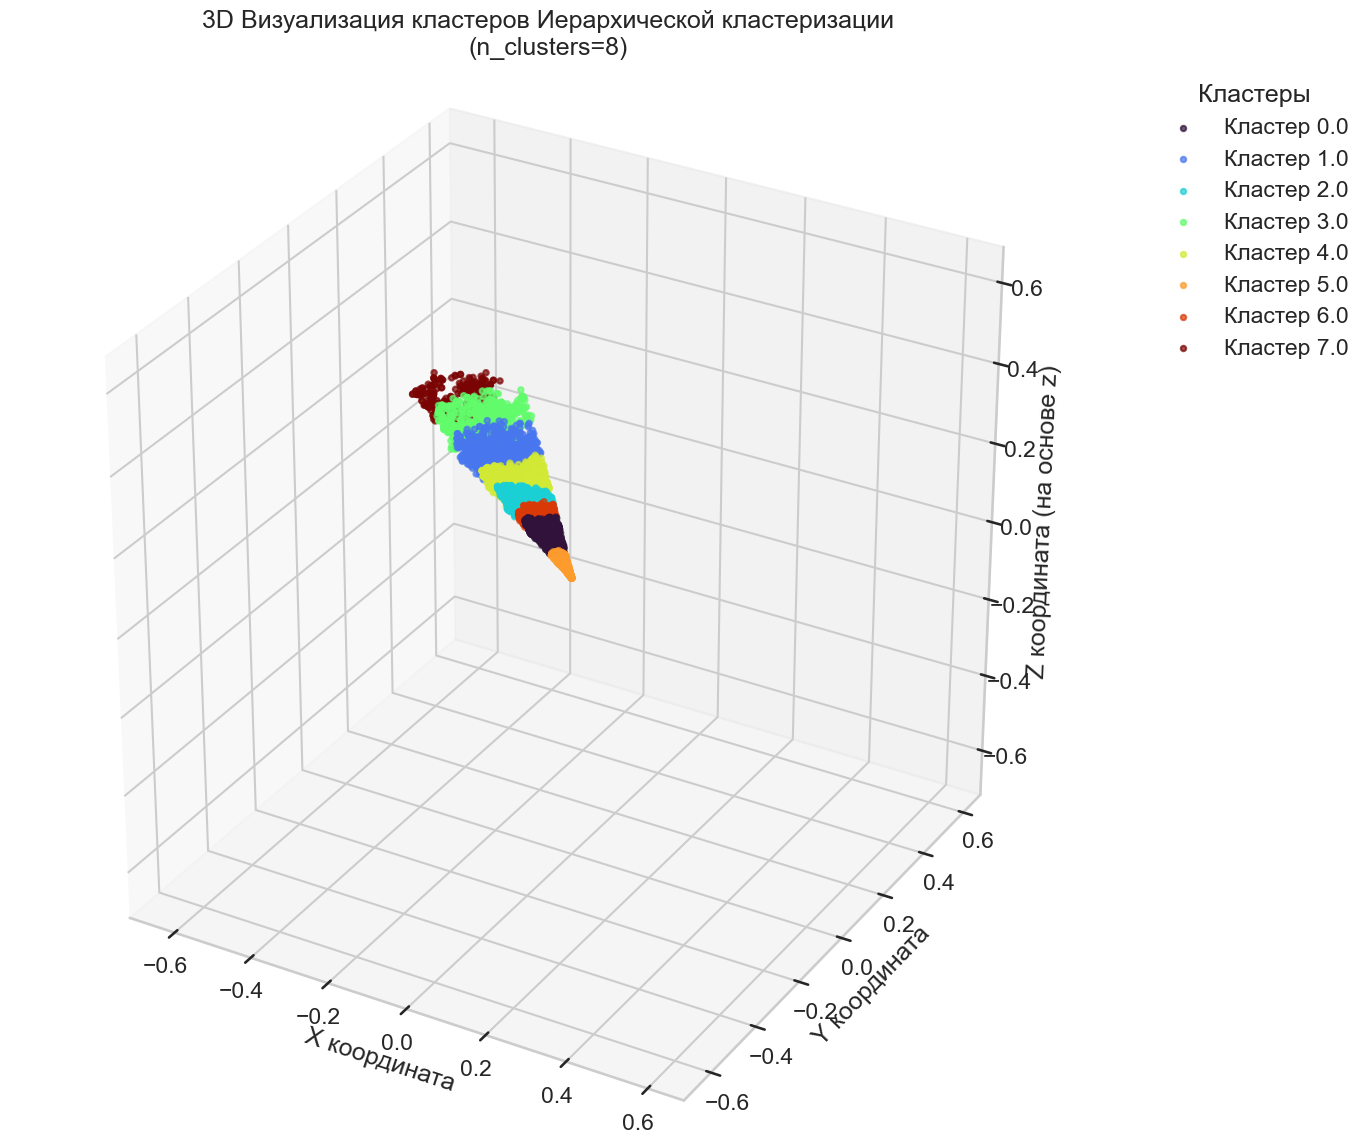

Интерактивный 3D график сохранен в: agglomerative_clusters_3d.html


In [ ]:
# Ячейка 18 - Визуализация кластеров Иерархической кластеризации

if 'df_lcc' in globals() and 'agglomerative_label' in df_lcc.columns and 'x_coord' in df_lcc.columns:
    
    df_plot_agg = df_lcc[df_lcc['agglomerative_label'].notna()].copy()
    
    if not df_plot_agg.empty:
        df_plot_agg.loc[:, 'agglomerative_label'] = df_plot_agg['agglomerative_label'].astype(int)

        fig_agg = plt.figure(figsize=(15, 12))
        ax_agg = fig_agg.add_subplot(111, projection='3d')

        unique_labels_agg = sorted(df_plot_agg['agglomerative_label'].unique())
        # n_clusters_to_plot_agg уже определено как n_clusters_agg при обучении модели
        n_clusters_to_plot_agg = globals().get('n_clusters_agg', len(unique_labels_agg))


        colors_map_agg = None
        if n_clusters_to_plot_agg > 0:
            try:
                colors_map_agg = plt.get_cmap('turbo', n_clusters_to_plot_agg)
            except ValueError:
                colors_map_agg = plt.get_cmap('turbo')
        
        sample_df_plot_agg = df_plot_agg

        cluster_legend_handles_agg = []
        cluster_ids_for_coloring_agg = sorted(unique_labels_agg) 
        cluster_color_index_map_agg = {label_val: i for i, label_val in enumerate(cluster_ids_for_coloring_agg)}


        for label_val in unique_labels_agg:
            cluster_mask_agg = sample_df_plot_agg['agglomerative_label'] == label_val
            if not np.any(cluster_mask_agg):
                continue

            current_color_agg = 'green'
            if colors_map_agg and n_clusters_to_plot_agg > 0:
                color_idx_for_map_agg = cluster_color_index_map_agg[label_val]
                color_value_agg = color_idx_for_map_agg / (n_clusters_to_plot_agg - 1) if n_clusters_to_plot_agg > 1 else 0.5
                current_color_agg = colors_map_agg(color_value_agg)
            elif colors_map_agg and n_clusters_to_plot_agg == 1:
                 current_color_agg = colors_map_agg(0.5)

            scatter_agg = ax_agg.scatter(sample_df_plot_agg.loc[cluster_mask_agg, 'x_coord'], 
                                         sample_df_plot_agg.loc[cluster_mask_agg, 'y_coord'], 
                                         sample_df_plot_agg.loc[cluster_mask_agg, 'z_cart_coord'], 
                                         color=current_color_agg, 
                                         label=f'Кластер {label_val}', s=15, alpha=0.7)
            cluster_legend_handles_agg.append(scatter_agg)

        ax_agg.set_xlabel('X координата')
        ax_agg.set_ylabel('Y координата')
        ax_agg.set_zlabel('Z координата (на основе z)')
        
        title_agg_parts = ["3D Визуализация кластеров Иерархической кластеризации"]
        if "n_clusters_agg" in globals():
            title_agg_parts.append(f"(n_clusters={n_clusters_agg})")
        ax_agg.set_title("\n".join(title_agg_parts))
        
        if len(cluster_legend_handles_agg) > 15:
            ax_agg.legend(handles=cluster_legend_handles_agg[:15], title="Кластеры (первые 15)", bbox_to_anchor=(1.05, 1), loc='upper left')
        elif cluster_legend_handles_agg:
            ax_agg.legend(handles=cluster_legend_handles_agg, title="Кластеры", bbox_to_anchor=(1.05, 1), loc='upper left')

        try:
            all_coords_plot_agg = sample_df_plot_agg[['x_coord', 'y_coord', 'z_cart_coord']].values.flatten()
            all_coords_plot_agg = all_coords_plot_agg[~np.isnan(all_coords_plot_agg)]
            if len(all_coords_plot_agg) > 0:
                coord_min_agg, coord_max_agg = np.min(all_coords_plot_agg), np.max(all_coords_plot_agg)
                ax_agg.set_xlim([coord_min_agg, coord_max_agg])
                ax_agg.set_ylim([coord_min_agg, coord_max_agg])
                ax_agg.set_zlim([coord_min_agg, coord_max_agg])
                ax_agg.set_box_aspect([1,1,1])
                print("Масштаб осей установлен одинаковым для Иерархической кластеризации.")
        except Exception as e_scale_agg:
            print(f"Не удалось установить одинаковый масштаб осей для Иерархической кластеризации: {e_scale_agg}")

        plt.tight_layout(rect=[0, 0, 0.85, 1])
        plt.show()

        try:
            interactive_fig_agg = go.Figure()
            for label_val in unique_labels_agg:
                cluster_mask_agg = sample_df_plot_agg['agglomerative_label'] == label_val
                if not np.any(cluster_mask_agg): continue
                
                current_color_str_agg = 'green'
                if colors_map_agg and n_clusters_to_plot_agg > 0:
                    color_idx_for_map_agg = cluster_color_index_map_agg[label_val]
                    color_value_agg = color_idx_for_map_agg / (n_clusters_to_plot_agg - 1) if n_clusters_to_plot_agg > 1 else 0.5
                    rgb_color_agg = colors_map_agg(color_value_agg, bytes=False)
                    current_color_str_agg = f'rgb({int(rgb_color_agg[0]*255)}, {int(rgb_color_agg[1]*255)}, {int(rgb_color_agg[2]*255)})'
                elif colors_map_agg and n_clusters_to_plot_agg == 1:
                    rgb_color_agg = colors_map_agg(0.5, bytes=False)
                    current_color_str_agg = f'rgb({int(rgb_color_agg[0]*255)}, {int(rgb_color_agg[1]*255)}, {int(rgb_color_agg[2]*255)})'

                interactive_fig_agg.add_trace(go.Scatter3d(
                    x=sample_df_plot_agg.loc[cluster_mask_agg, 'x_coord'],
                    y=sample_df_plot_agg.loc[cluster_mask_agg, 'y_coord'],
                    z=sample_df_plot_agg.loc[cluster_mask_agg, 'z_cart_coord'],
                    mode='markers',
                    marker=dict(size=3, color=current_color_str_agg, opacity=0.7),
                    name=f'Кластер {label_val}'
                ))
            
            title_str_plotly_agg = f'3D Кластеры Иерархической кластеризации (n_clusters={n_clusters_agg if "n_clusters_agg" in globals() else "N/A"})'
            interactive_fig_agg.update_layout(
                title=title_str_plotly_agg,
                scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z', aspectmode='cube'),
                margin=dict(l=0, r=0, b=0, t=40)
            )
            interactive_filename_agg = "agglomerative_clusters_3d.html"
            interactive_fig_agg.write_html(interactive_filename_agg)
            print(f"Интерактивный 3D график сохранен в: {interactive_filename_agg}")

        except Exception as e_plotly_agg:
            print(f"Ошибка при создании интерактивного графика Plotly для Иерархической кластеризации: {e_plotly_agg}")
            
    else:
        print("Нет данных для визуализации кластеров Иерархической кластеризации.")
else:
    print("DataFrame 'df_lcc' или необходимые столбцы ('agglomerative_label', 'x_coord') не найдены. Визуализация невозможна.")


--- Сравнение результатов кластеризации ---
Создана директория: comparison_outputs

Сводная таблица метрик кластеризации:
                          Silhouette Score  Davies-Bouldin Index  Время (сек)  Целевое кол-во кластеров  Шум  Объекты с меткой -2
DBSCAN                            0.361895              1.672337     0.119762                        12  203                    0
Spectral Clustering               0.466061              0.859014     6.661046                         8    0                  344
Agglomerative Clustering          0.357475              0.904576     1.352336                         8    0                    0
Сводная таблица сохранена в: comparison_outputs/metrics_comparison_table.html
Сводная таблица сохранена в: comparison_outputs/metrics_comparison_table.md
График сравнения метрик сохранен в: comparison_outputs/metrics_comparison_plot.png


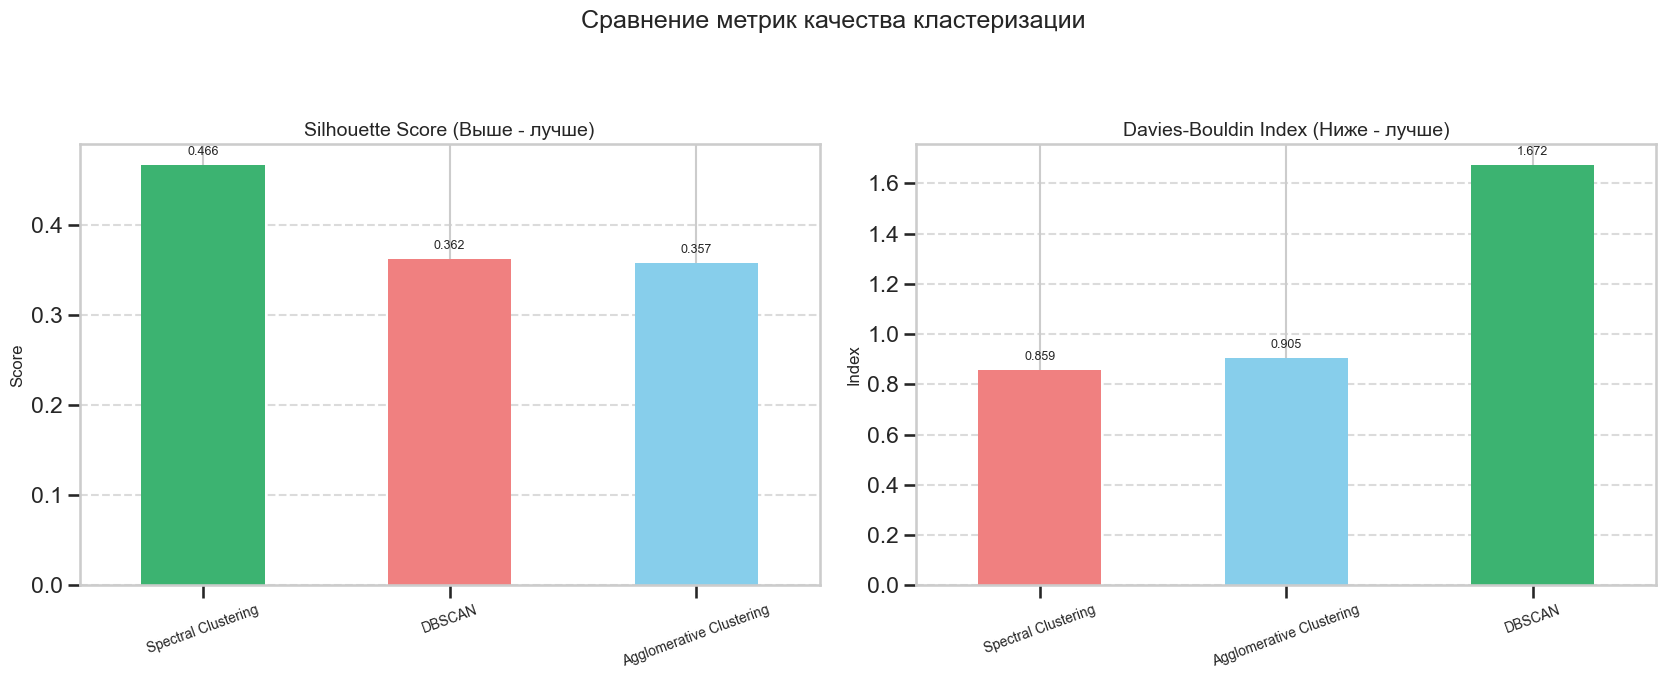


--- Сравнение меток: DBSCAN vs Spectral (на сэмпле из LCC) ---
График сравнения DBSCAN vs Spectral сохранен в: comparison_outputs/dbscan_vs_spectral_comparison.png


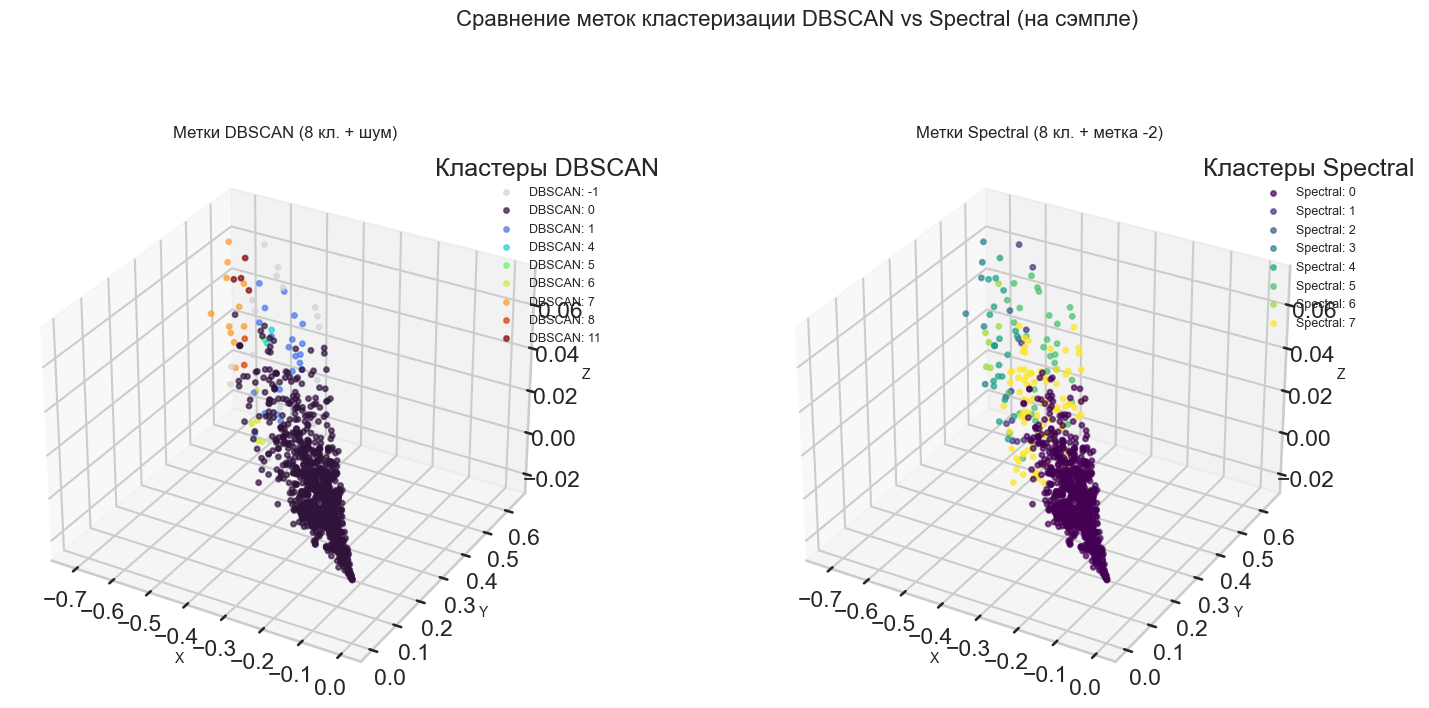

In [31]:
# Ячейка 19 - Сравнение результатов кластеризации

results_summary = {}
labels_exist = True
output_dir = "comparison_outputs" 
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Создана директория: {output_dir}")

if 'labels_dbscan' in locals() and 'n_clusters_dbscan' in locals() and \
   'silhouette_avg_dbscan' in locals() and 'davies_bouldin_avg_dbscan' in locals():
    time_dbscan = globals().get('time_dbscan_exec', float('nan'))
    results_summary['DBSCAN'] = {
        'Silhouette Score': silhouette_avg_dbscan,
        'Davies-Bouldin Index': davies_bouldin_avg_dbscan,
        'Время (сек)': time_dbscan,
        'Целевое кол-во кластеров': n_clusters_dbscan,
        'Шум': list(labels_dbscan).count(-1),
        'Объекты с меткой -2': 0
    }
else:
    print("ПРЕДУПРЕЖДЕНИЕ: Данные для DBSCAN неполные или отсутствуют.")
    labels_exist = False

if 'n_clusters_spectral' in locals() and \
   'silhouette_avg_spectral' in locals() and 'davies_bouldin_avg_spectral' in locals() and \
   'df_lcc' in locals() and 'spectral_label' in df_lcc.columns: # Проверяем наличие метки в df_lcc
    
    time_spectral = globals().get('execution_time_spectral', float('nan')) 
    
    objects_minus_2_spectral = list(df['spectral_label']).count(-2) if 'spectral_label' in df.columns else 0
        
    results_summary['Spectral Clustering'] = {
        'Silhouette Score': silhouette_avg_spectral,
        'Davies-Bouldin Index': davies_bouldin_avg_spectral,
        'Время (сек)': time_spectral,
        'Целевое кол-во кластеров': n_clusters_spectral, 
        'Шум': 0, 
        'Объекты с меткой -2': objects_minus_2_spectral 
    }
else:
    print("ПРЕДУПРЕЖДЕНИЕ: Данные для Спектральной кластеризации неполные или отсутствуют (проверьте df_lcc['spectral_label'] и метрики).")
    labels_exist = False
    
if 'labels_agg' in locals() and 'n_clusters_agg' in locals() and \
   'silhouette_avg_agg' in locals() and 'davies_bouldin_avg_agg' in locals():
    time_agg = globals().get('execution_time_agg', float('nan'))
    results_summary['Agglomerative Clustering'] = {
        'Silhouette Score': silhouette_avg_agg,
        'Davies-Bouldin Index': davies_bouldin_avg_agg,
        'Время (сек)': time_agg,
        'Целевое кол-во кластеров': n_clusters_agg,
        'Шум': 0, 
        'Объекты с меткой -2': 0
    }
else:
    print("ПРЕДУПРЕЖДЕНИЕ: Данные для Иерархической кластеризации неполные или отсутствуют.")
    labels_exist = False

if results_summary and labels_exist:
    results_df = pd.DataFrame.from_dict(results_summary, orient='index')
    cols_ordered = ['Silhouette Score', 'Davies-Bouldin Index', 'Время (сек)', 'Целевое кол-во кластеров', 'Шум', 'Объекты с меткой -2']
    results_df = results_df[cols_ordered] # Упорядочиваем столбцы

    print("\nСводная таблица метрик кластеризации:")
    print(results_df.to_string())
    
    table_html_path = os.path.join(output_dir, "metrics_comparison_table.html")
    try:
        results_df.to_html(table_html_path, float_format='%.3f', border=1, classes='table table-striped table-hover')
        print(f"Сводная таблица сохранена в: {table_html_path}")
    except Exception as e_html:
        print(f"Ошибка при сохранении таблицы в HTML: {e_html}")

    table_md_path = os.path.join(output_dir, "metrics_comparison_table.md")
    try:
        with open(table_md_path, 'w') as f:
            f.write(results_df.to_markdown())
        print(f"Сводная таблица сохранена в: {table_md_path}")
    except Exception as e_md:
        print(f"Ошибка при сохранении таблицы в Markdown: {e_md}")


    if not results_df.empty:
        fig_metrics, axes_metrics = plt.subplots(1, 2, figsize=(17, 7))
        
        results_df['Silhouette Score'].sort_values(ascending=False).plot(kind='bar', ax=axes_metrics[0], color=['mediumseagreen', 'lightcoral', 'skyblue', 'gold'])
        axes_metrics[0].set_title('Silhouette Score (Выше - лучше)', fontsize=14)
        axes_metrics[0].set_ylabel('Score', fontsize=12)
        axes_metrics[0].tick_params(axis='x', rotation=20, labelsize=10) 
        axes_metrics[0].grid(axis='y', linestyle='--', alpha=0.7)
        for p in axes_metrics[0].patches:
            axes_metrics[0].annotate(f"{p.get_height():.3f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                                     ha='center', va='bottom', xytext=(0, 5), textcoords='offset points', fontsize=9)

        results_df['Davies-Bouldin Index'].sort_values(ascending=True).plot(kind='bar', ax=axes_metrics[1], color=['lightcoral', 'skyblue', 'mediumseagreen', 'gold'])
        axes_metrics[1].set_title('Davies-Bouldin Index (Ниже - лучше)', fontsize=14)
        axes_metrics[1].set_ylabel('Index', fontsize=12)
        axes_metrics[1].tick_params(axis='x', rotation=20, labelsize=10) 
        axes_metrics[1].grid(axis='y', linestyle='--', alpha=0.7)
        for p in axes_metrics[1].patches:
            axes_metrics[1].annotate(f"{p.get_height():.3f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                                     ha='center', va='bottom', xytext=(0, 5), textcoords='offset points', fontsize=9)
            
        plt.suptitle('Сравнение метрик качества кластеризации', fontsize=18, y=0.98)
        plt.tight_layout(rect=[0, 0, 1, 0.93])
        
        metrics_plot_path = os.path.join(output_dir, "metrics_comparison_plot.png")
        try:
            plt.savefig(metrics_plot_path, dpi=150, bbox_inches='tight')
            print(f"График сравнения метрик сохранен в: {metrics_plot_path}")
        except Exception as e_plot:
            print(f"Ошибка при сохранении графика метрик: {e_plot}")
        plt.show()
        
        if 'df_lcc' in locals() and 'dbscan_label' in df_lcc.columns and 'spectral_label' in df_lcc.columns and not df_lcc.empty:
            print("\n--- Сравнение меток: DBSCAN vs Spectral (на сэмпле из LCC) ---")
            
            sample_size = min(1000, len(df_lcc)) 
            df_compare_sample = df_lcc.sample(n=sample_size, random_state=42)

            fig_compare_ds = plt.figure(figsize=(18, 7)) 
            
            ax1_ds = fig_compare_ds.add_subplot(121, projection='3d')
            unique_dbscan_labels = sorted(df_compare_sample['dbscan_label'].astype(int).unique())
            
            num_dbscan_clusters_for_palette = len([l for l in unique_dbscan_labels if l != -1])
            dbscan_cmap = plt.get_cmap('turbo', num_dbscan_clusters_for_palette if num_dbscan_clusters_for_palette > 0 else 1)
            dbscan_color_map = {label: dbscan_cmap(i) for i, label in enumerate(sorted([l for l in unique_dbscan_labels if l != -1]))}
            dbscan_color_map[-1] = 'lightgray' 

            for label_val in unique_dbscan_labels:
                subset = df_compare_sample[df_compare_sample['dbscan_label'] == label_val]
                if not subset.empty:
                    ax1_ds.scatter(subset['x_coord'], subset['y_coord'], subset['z_cart_coord'], 
                                   color=dbscan_color_map.get(label_val, 'black'), 
                                   label=f'DBSCAN: {label_val}', s=12, alpha=0.65)
            ax1_ds.set_title(f'Метки DBSCAN ({num_dbscan_clusters_for_palette} кл. + шум)', fontsize=12)
            ax1_ds.set_xlabel('X', fontsize=10); ax1_ds.set_ylabel('Y', fontsize=10); ax1_ds.set_zlabel('Z', fontsize=10)
            if len(unique_dbscan_labels) <=10 : ax1_ds.legend(title="Кластеры DBSCAN", bbox_to_anchor=(1.2, 1), fontsize=9)

            ax2_ds = fig_compare_ds.add_subplot(122, projection='3d')
            unique_spectral_labels = sorted(df_compare_sample['spectral_label'].astype(int).unique())

            num_spectral_clusters_for_palette = len([l for l in unique_spectral_labels if l != -2])
            spectral_cmap = plt.get_cmap('viridis', num_spectral_clusters_for_palette if num_spectral_clusters_for_palette > 0 else 1)
            spectral_color_map = {label: spectral_cmap(i) for i, label in enumerate(sorted([l for l in unique_spectral_labels if l != -2]))}
            spectral_color_map[-2] = 'silver' # Метка -2

            for label_val in unique_spectral_labels:
                subset = df_compare_sample[df_compare_sample['spectral_label'] == label_val]
                if not subset.empty:
                     ax2_ds.scatter(subset['x_coord'], subset['y_coord'], subset['z_cart_coord'], 
                                   color=spectral_color_map.get(label_val, 'black'), 
                                   label=f'Spectral: {label_val}', s=12, alpha=0.65)
            ax2_ds.set_title(f'Метки Spectral ({num_spectral_clusters_for_palette} кл. + метка -2)', fontsize=12)
            ax2_ds.set_xlabel('X', fontsize=10); ax2_ds.set_ylabel('Y', fontsize=10); ax2_ds.set_zlabel('Z', fontsize=10)
            if len(unique_spectral_labels) <=10 : ax2_ds.legend(title="Кластеры Spectral", bbox_to_anchor=(1.2, 1), fontsize=9)
            
            plt.suptitle("Сравнение меток кластеризации DBSCAN vs Spectral (на сэмпле)", fontsize=16, y=1.02) 
            plt.tight_layout(rect=[0, 0, 0.88, 0.96]) 

            compare_plot_path = os.path.join(output_dir, "dbscan_vs_spectral_comparison.png")
            try:
                plt.savefig(compare_plot_path, dpi=150, bbox_inches='tight')
                print(f"График сравнения DBSCAN vs Spectral сохранен в: {compare_plot_path}")
            except Exception as e_plot_compare:
                print(f"Ошибка при сохранении графика сравнения DBSCAN vs Spectral: {e_plot_compare}")
            plt.show()
        else:
            print("ПРЕДУПРЕЖДЕНИЕ: Недостаточно данных для построения сравнительных scatter plot'ов (нужны 'dbscan_label' и 'spectral_label' в df_lcc).")
else:
    print("Нет полных данных для одного или нескольких методов кластеризации. Сравнение невозможно.")
